## Task 1: Credit Card Routing for Online Purchase via Predictive Modelling

### Problem statement
* Over the past year, the online payment department at a large retail company have encountered a high failure rate of online credit card payments done via so-called payment service providers, referred to as PSP's by the business stakeholders.
* The company losses alot of money due to failed transactions and customers have become increasingly unsatisfied with the online shop.
* The current routing logic is manual and rule-based. Business decision makers hope that with predictive modelling, a smarter way of routing a PSP to a transaction is possible.

### Data Science Task
* Help the business to automate the credit card routing via a predictive model
* Such a model should increase the payment success rate by finding the best possible PSP for each transaction and at the same time keep the transaction fees low.

# PART 2: Univariate Analysis

### Import Key Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook 
from bokeh.palettes import Spectral
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show

### Read Dataset

In [3]:
dataset = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

In [4]:
dataset.head()

Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners

In [5]:
dataset = dataset.drop('Unnamed: 0', axis=1)

In [6]:
dataset.head()

tmsp  country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11  Germany      89        0     UK_Card           0   
1 2019-01-01 00:01:17  Germany      89        1     UK_Card           0   
2 2019-01-01 00:02:49  Germany     238        0     UK_Card           1   
3 2019-01-01 00:03:13  Germany     238        1     UK_Card           1   
4 2019-01-01 00:04:33  Austria     124        0  Simplecard           0   

     card  
0    Visa  
1    Visa  
2  Diners  
3  Diners  
4  Diners

### Remove Duplicates

In [7]:
dataset.sort_values(["tmsp", "country", "amount"], axis = 0, ascending = True, inplace = True, na_position = "first")

In [8]:
dataset.reset_index(inplace=True, drop=True)

In [9]:
dataset.head(10)

tmsp      country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11      Germany      89        0     UK_Card           0   
1 2019-01-01 00:01:17      Germany      89        1     UK_Card           0   
2 2019-01-01 00:02:49      Germany     238        0     UK_Card           1   
3 2019-01-01 00:03:13      Germany     238        1     UK_Card           1   
4 2019-01-01 00:04:33      Austria     124        0  Simplecard           0   
5 2019-01-01 00:06:41  Switzerland     282        0     UK_Card           0   
6 2019-01-01 00:07:19  Switzerland     282        0  Simplecard           0   
7 2019-01-01 00:08:46      Germany     117        1     UK_Card           0   
8 2019-01-01 00:09:56  Switzerland     174        0  Simplecard           0   
9 2019-01-01 00:10:49  Switzerland     174        0  Simplecard           0   

     card  
0    Visa  
1    Visa  
2  Diners  
3  Diners  
4  Diners  
5  Master  
6  Master  
7  Master  
8    Visa  
9    Visa

In [10]:
dataset["time_delta"] = (dataset["tmsp"]-dataset["tmsp"].shift(1)).dt.total_seconds()

In [11]:
dataset["time_delta"] = dataset["time_delta"].fillna(0)

In [12]:
same_tx = (dataset["time_delta"]>60).cumsum()
dataset['tx_number'] = dataset.groupby(same_tx).ngroup()

In [13]:
#dataset.to_excel("dataset_check.xlsx")

In [14]:
dataset.head(1)

tmsp  country  amount  success      PSP  3D_secured  card  \
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa   

   time_delta  tx_number  
0         0.0          0

In [15]:
dataset.drop_duplicates(subset=['tx_number', 'PSP'], keep='first', inplace=True)

### Update index

In [16]:
# make timestamp the index for easier analysis
dataset = dataset.set_index(dataset.columns[0])

In [17]:
dataset.head()

country  amount  success         PSP  3D_secured  \
tmsp                                                                        
2019-01-01 00:01:11      Germany      89        0     UK_Card           0   
2019-01-01 00:02:49      Germany     238        0     UK_Card           1   
2019-01-01 00:04:33      Austria     124        0  Simplecard           0   
2019-01-01 00:06:41  Switzerland     282        0     UK_Card           0   
2019-01-01 00:07:19  Switzerland     282        0  Simplecard           0   

                       card  time_delta  tx_number  
tmsp                                                
2019-01-01 00:01:11    Visa         0.0          0  
2019-01-01 00:02:49  Diners        92.0          1  
2019-01-01 00:04:33  Diners        80.0          2  
2019-01-01 00:06:41  Master       128.0          3  
2019-01-01 00:07:19  Master        38.0          3

In [18]:
# add a feature field to hold the order of the dates - for the base model
dataset['date_order'] = np.arange(len(dataset.index))

#### Identify fields with missing data

In [19]:
# Print the number of missing entries in each column
print(dataset.isna().sum())

country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
time_delta    0
tx_number     0
date_order    0
dtype: int64


#### Identify fields with missing data

In [20]:
dataset.head()

country  amount  success         PSP  3D_secured  \
tmsp                                                                        
2019-01-01 00:01:11      Germany      89        0     UK_Card           0   
2019-01-01 00:02:49      Germany     238        0     UK_Card           1   
2019-01-01 00:04:33      Austria     124        0  Simplecard           0   
2019-01-01 00:06:41  Switzerland     282        0     UK_Card           0   
2019-01-01 00:07:19  Switzerland     282        0  Simplecard           0   

                       card  time_delta  tx_number  date_order  
tmsp                                                            
2019-01-01 00:01:11    Visa         0.0          0           0  
2019-01-01 00:02:49  Diners        92.0          1           1  
2019-01-01 00:04:33  Diners        80.0          2           2  
2019-01-01 00:06:41  Master       128.0          3           3  
2019-01-01 00:07:19  Master        38.0          3           4

## 2. Building the Actual Refined Models (based on CRISP-DM)

### CRISP-DM (1) - Business Understanding  (Exploratory Data Analysis)
* Univariate analysis
* Understand the business as it is given in the task
* As part of the EDA, what does the data tell us about the business?

## Univariate Analysis

In [21]:
# reset_dataset
dataset_time = dataset.copy().reset_index()
dataset_time.head()

tmsp      country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11      Germany      89        0     UK_Card           0   
1 2019-01-01 00:02:49      Germany     238        0     UK_Card           1   
2 2019-01-01 00:04:33      Austria     124        0  Simplecard           0   
3 2019-01-01 00:06:41  Switzerland     282        0     UK_Card           0   
4 2019-01-01 00:07:19  Switzerland     282        0  Simplecard           0   

     card  time_delta  tx_number  date_order  
0    Visa         0.0          0           0  
1  Diners        92.0          1           1  
2  Diners        80.0          2           2  
3  Master       128.0          3           3  
4  Master        38.0          3           4

In [22]:
dataset_time.describe()

tmsp        amount       success  \
count                          37932  37932.000000  37932.000000   
mean   2019-01-30 01:04:45.160286976    202.075662      0.205868   
min              2019-01-01 00:01:11      6.000000      0.000000   
25%       2019-01-15 00:21:05.500000    133.000000      0.000000   
50%       2019-01-30 19:25:16.500000    200.000000      0.000000   
75%    2019-02-13 10:45:29.249999872    268.000000      0.000000   
max              2019-02-28 23:48:19    630.000000      1.000000   
std                              NaN     96.263346      0.404340   

         3D_secured    time_delta     tx_number    date_order  
count  37932.000000  37932.000000  37932.000000  37932.000000  
mean       0.238875    125.420621  13530.406807  18965.500000  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000     51.000000   6645.000000   9482.750000  
50%        0.000000     97.000000  13683.500000  18965.500000  
75%        0.000000    168.000000  20296.000000  28448.250000  
max        1.000000   1328.000000  27229.000000  37931.000000  
std        0.426402    109.212079   7901.500879  10950.169542

In [23]:
# statistical spread of numeric features
dataset_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37932 entries, 0 to 37931
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        37932 non-null  datetime64[ns]
 1   country     37932 non-null  object        
 2   amount      37932 non-null  int64         
 3   success     37932 non-null  int64         
 4   PSP         37932 non-null  object        
 5   3D_secured  37932 non-null  int64         
 6   card        37932 non-null  object        
 7   time_delta  37932 non-null  float64       
 8   tx_number   37932 non-null  int64         
 9   date_order  37932 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(3)
memory usage: 2.7+ MB


### Plot statistical distribution of feature variables

###### Plot statistical distribution of Amount

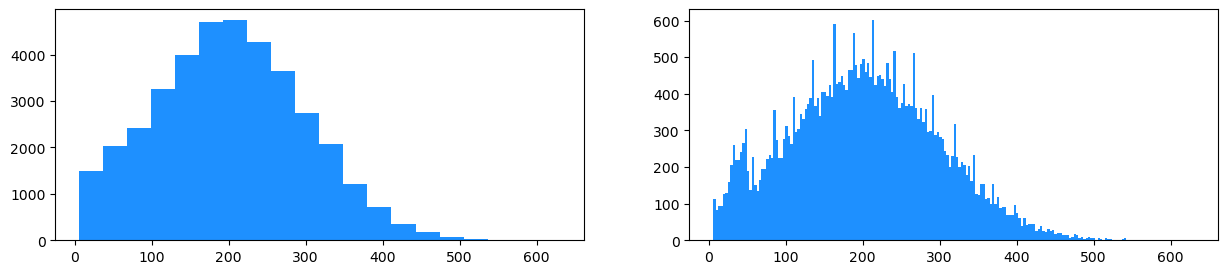

In [24]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
ax[0].hist(dataset_time['amount'], bins=20, color='dodgerblue')
ax[1].hist(dataset_time['amount'], bins=200, color='dodgerblue')
plt.show()

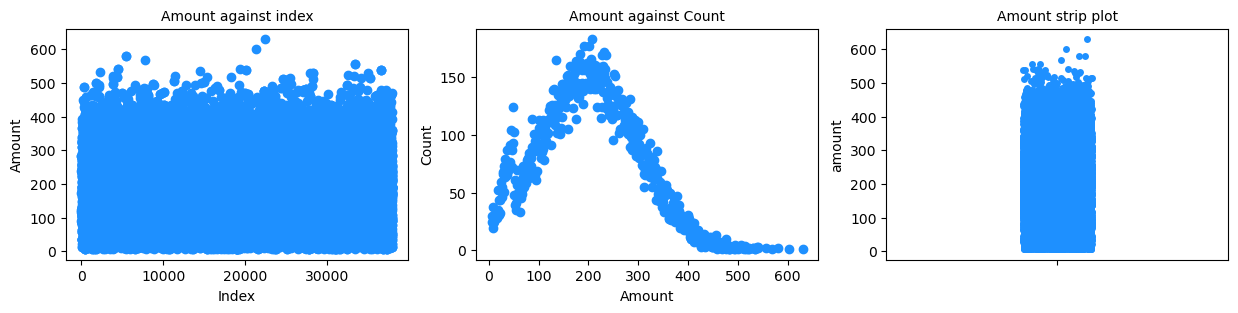

In [25]:
# Scatter and strip plot plot - one
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax[0].scatter(dataset_time.index, dataset_time.amount, color='dodgerblue')
ax[0].set_title('Amount against index', fontsize=10)
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Amount')

amount_count = dataset_time.groupby('amount')['PSP'].count().reset_index().rename(columns={'PSP':'count'}).copy()
ax[1].scatter(amount_count['amount'],amount_count['count'], color='dodgerblue')
ax[1].set_title('Amount against Count', fontsize=10)
ax[1].set_xlabel('Amount')
ax[1].set_ylabel('Count')

ax[2] = sns.stripplot(y=dataset_time['amount'], color='dodgerblue')
ax[2].set_title('Amount strip plot', fontsize=10)

plt.show()

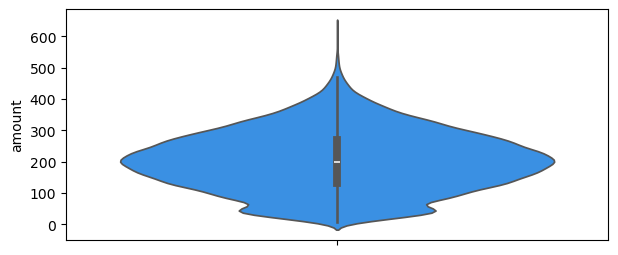

In [26]:
## Violin plot
from matplotlib.pyplot import figure
figure(figsize=(7, 3))
sns.violinplot(dataset_time['amount'], orient='vertical', color='dodgerblue')
plt.show()

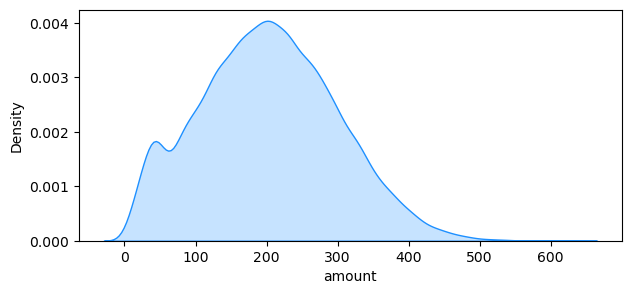

In [27]:
# Density plot
from matplotlib.pyplot import figure
figure(figsize=(7, 3))
sns.kdeplot(dataset_time['amount'], color='dodgerblue', fill=True)
plt.show()

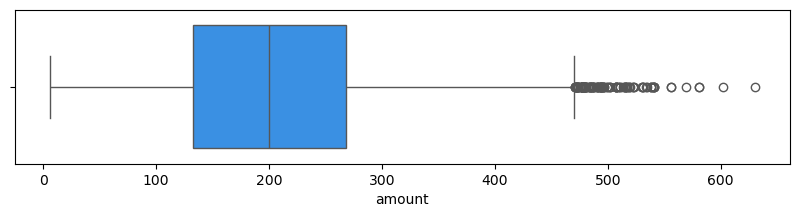

In [28]:
# Box plot
from matplotlib.pyplot import figure
figure(figsize=(10, 2))
sns.boxplot(dataset_time['amount'], color='dodgerblue', orient='h')
plt.show()

##### Plot statistical distribution of categorical variables

In [29]:
def plot_dist_cat_feature(df=dataset_time, cat_feature='country', fig_size=(15,10), color='dodgerblue', labels=['Germany', 'Switzerland', 'Austria']):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=fig_size)
    if cat_feature in ['success', '3D_secured']:
        ax[0,0] = dataset_time['success'].value_counts().plot.bar(ax=ax[0,0], color='dodgerblue')
    else:
        ax[0,0] = sns.countplot(df[cat_feature], color=color, ax=ax[0,0])
    ax[0,0].set_title("Count plot - {}".format(cat_feature))
    ax[0,1].pie(df[cat_feature].value_counts(), startangle=90, autopct='%.1f', labels=labels)
    ax[0,1].set_title("Pie chart - {}".format(cat_feature))
    ax[1,0] = sns.boxplot(x=df[cat_feature], y=df['amount'], color=color, ax=ax[1,0])
    ax[1,0].set_title("Boxplot - {} against amount".format(cat_feature))
    ax[1,1] = sns.violinplot(x=df[cat_feature], y=df['amount'], color=color, ax=ax[1,1])
    ax[1,1].set_title("Violin plot - {} against amount".format(cat_feature))
    plt.tight_layout() 
    plt.show

###### Plot statistical distribution of country

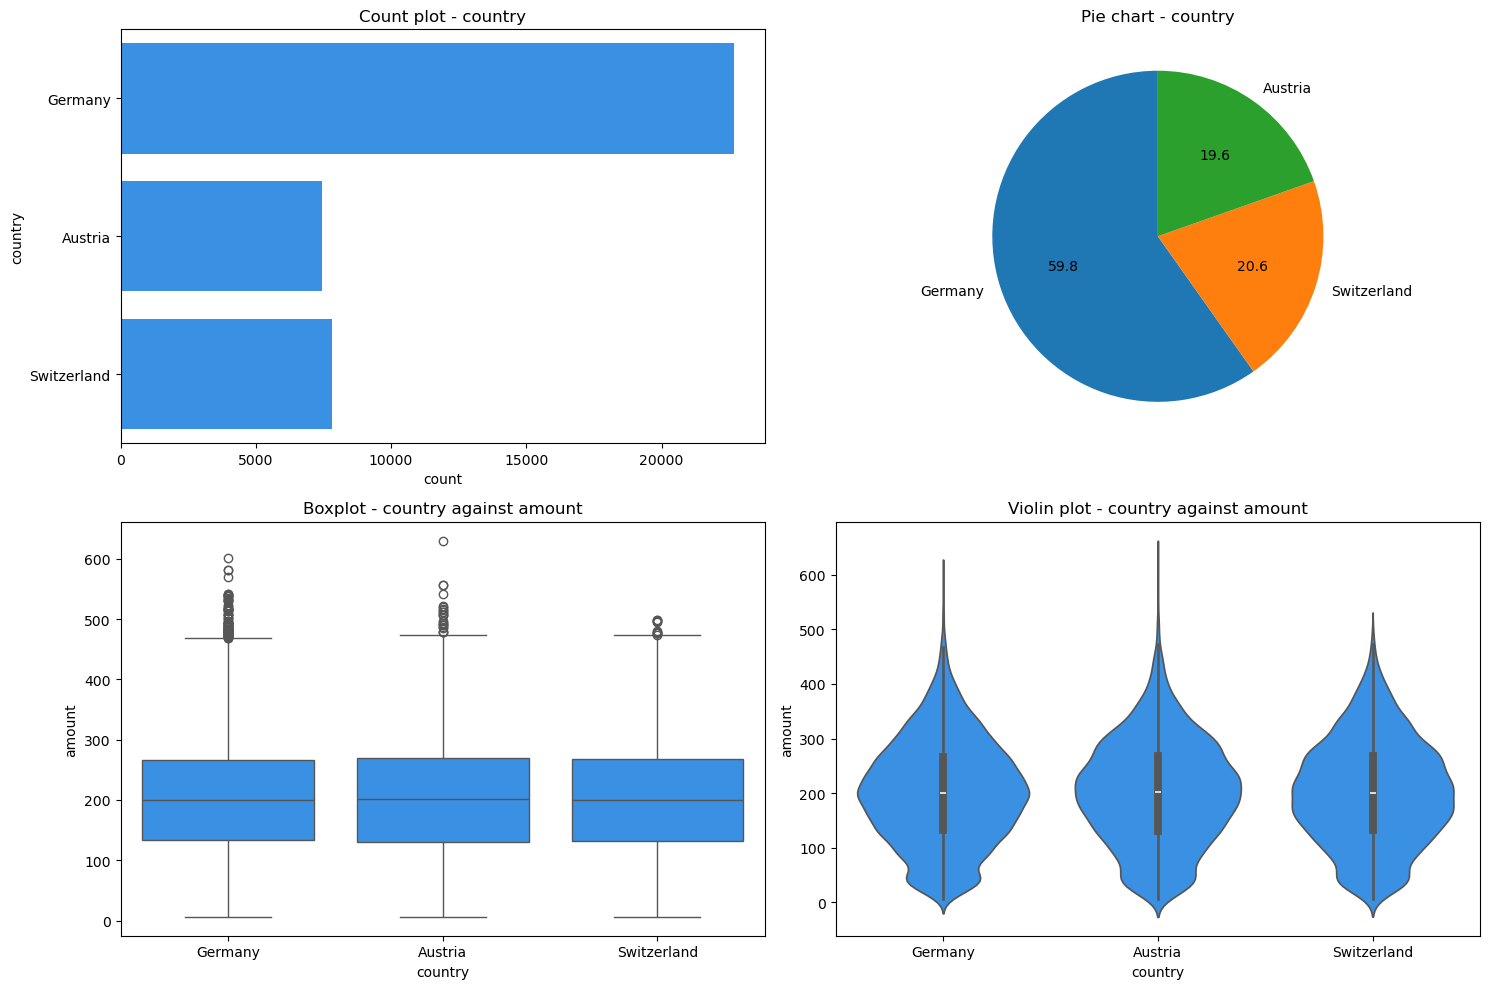

In [30]:
plot_dist_cat_feature(dataset_time, cat_feature='country', labels=['Germany', 'Switzerland', 'Austria'])

###### Plot statistical distribution of success

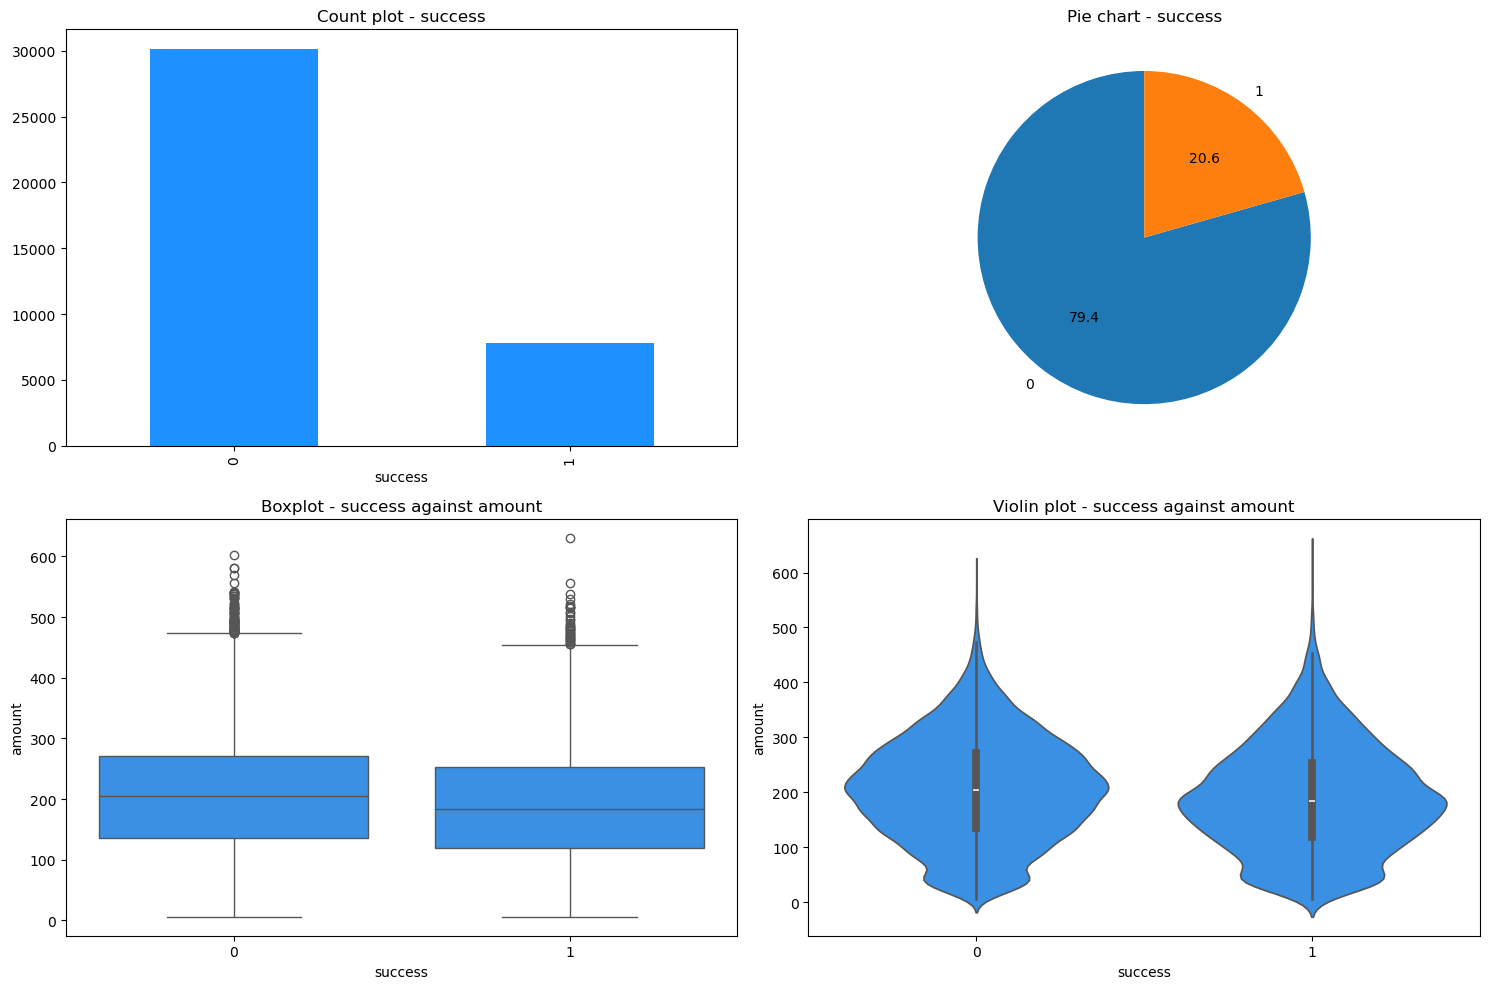

In [31]:
plot_dist_cat_feature(dataset_time, cat_feature='success', labels=['0','1'])

###### Plot statistical distribution of PSP

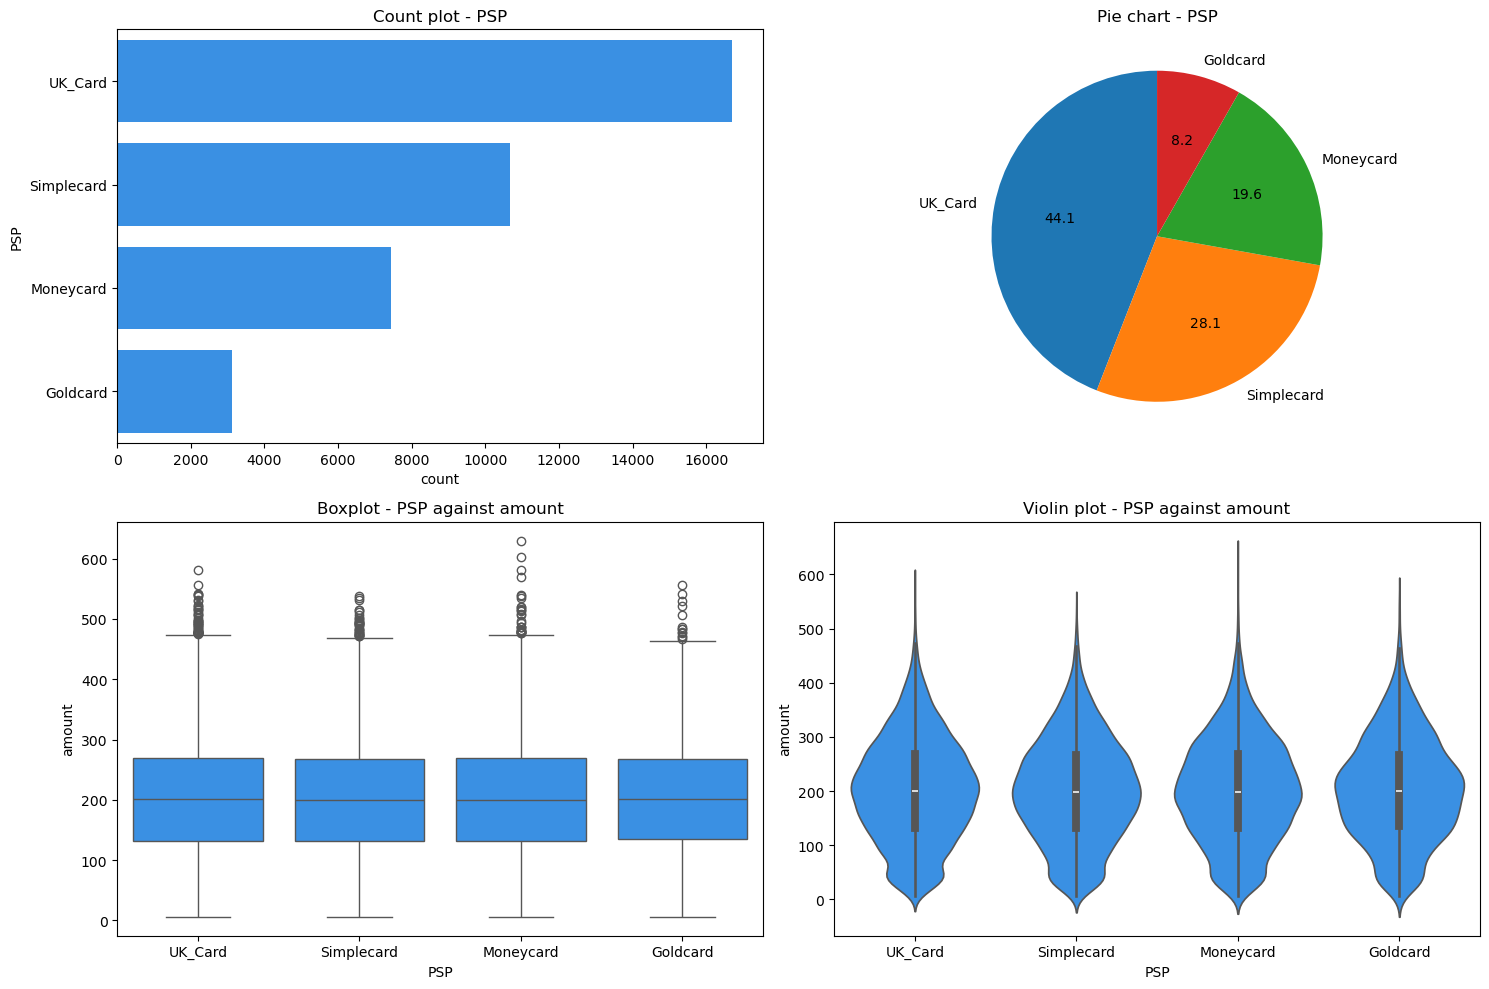

In [32]:
plot_dist_cat_feature(dataset_time, cat_feature='PSP', labels=['UK_Card', 'Simplecard', 'Moneycard', 'Goldcard'])

###### Plot statistical distribution of 3D_secured

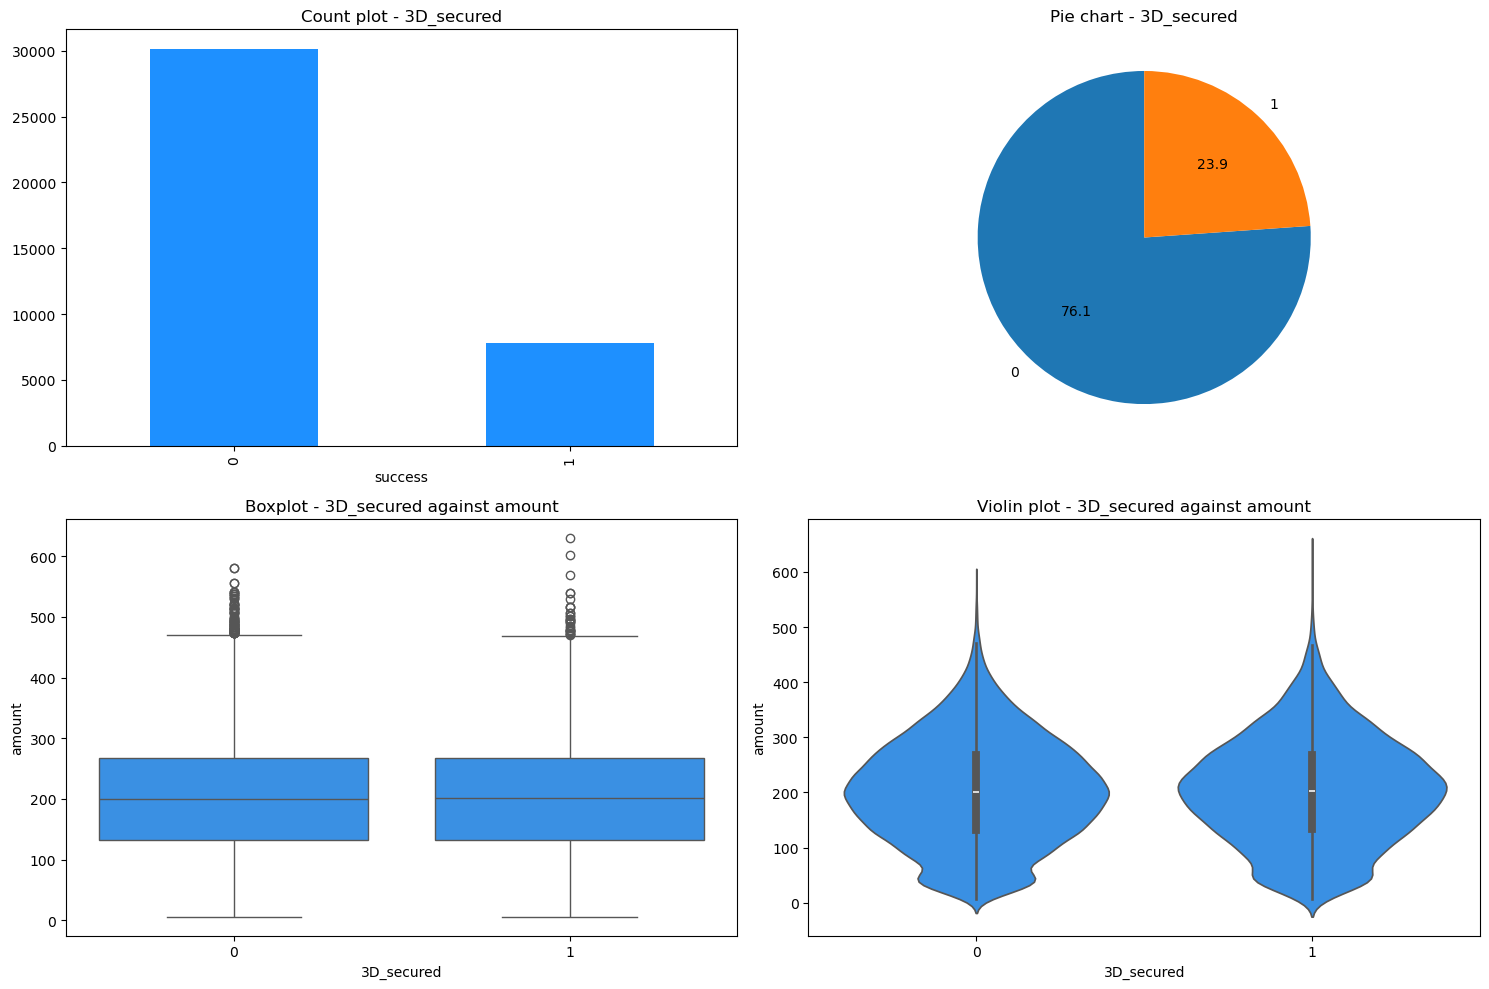

In [33]:
plot_dist_cat_feature(dataset_time, cat_feature='3D_secured', labels=['0','1'])

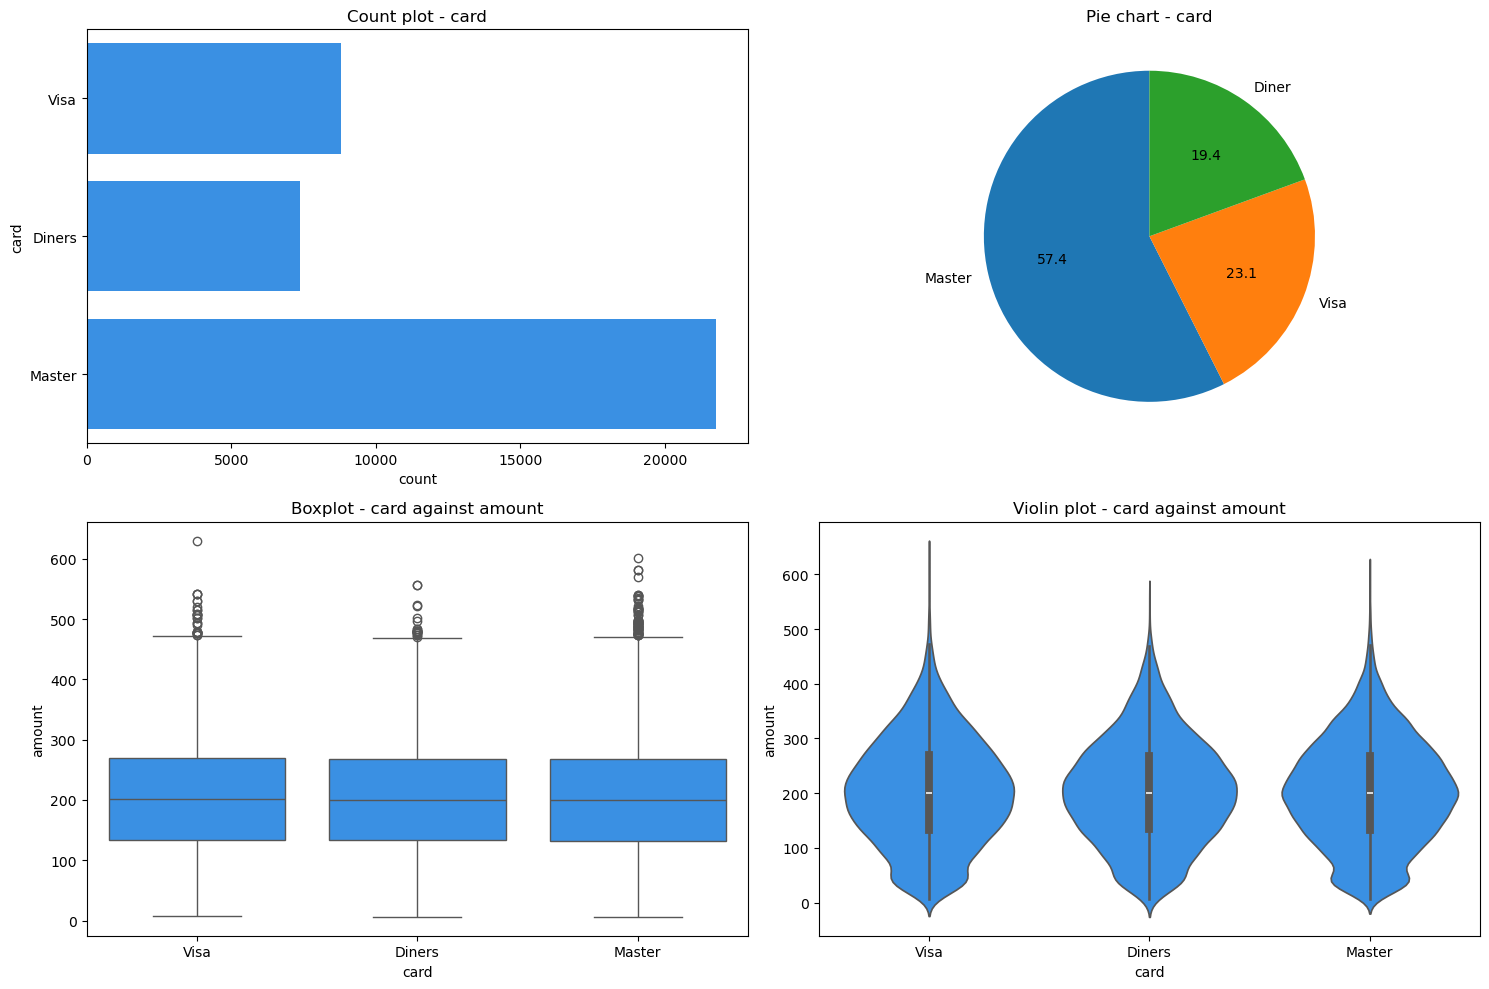

In [34]:
plot_dist_cat_feature(dataset_time, cat_feature='card', labels=['Master','Visa','Diner'])

### Plot timeseries data

###### Plot Amount time series

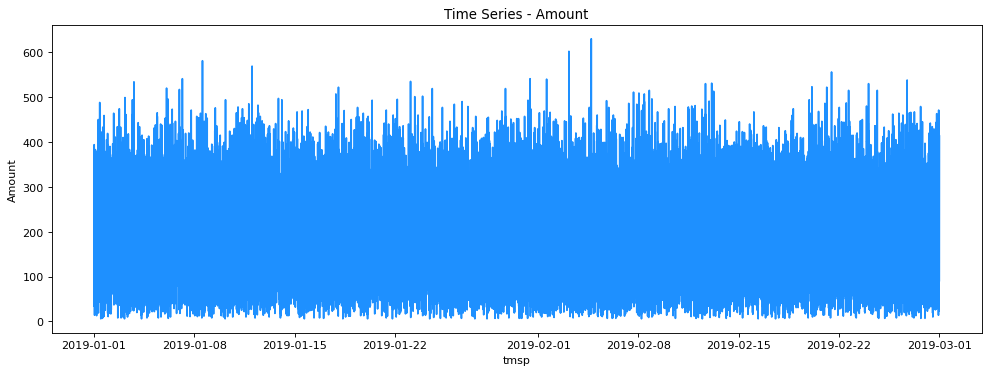

In [35]:
# Create line graph for the amount column
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80)
plt.plot(dataset_time["tmsp"], dataset_time["amount"], color='dodgerblue')
plt.xlabel('tmsp')
plt.ylabel('Amount')
plt.title('Time Series - Amount')
plt.show()

#### Plot Country, Success, PSP, 3D_secured, card time series

In [36]:
dataset_time = dataset.copy().reset_index()
dataset_time.head()

tmsp      country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11      Germany      89        0     UK_Card           0   
1 2019-01-01 00:02:49      Germany     238        0     UK_Card           1   
2 2019-01-01 00:04:33      Austria     124        0  Simplecard           0   
3 2019-01-01 00:06:41  Switzerland     282        0     UK_Card           0   
4 2019-01-01 00:07:19  Switzerland     282        0  Simplecard           0   

     card  time_delta  tx_number  date_order  
0    Visa         0.0          0           0  
1  Diners        92.0          1           1  
2  Diners        80.0          2           2  
3  Master       128.0          3           3  
4  Master        38.0          3           4

In [37]:
#### create a numeric value for country
def encode_country(country):
    if country=="Austria":
        return 0
    if country=="Germany":
        return 1
    if country =="Switzerland":
        return 2

In [38]:
#### create a numeric value for card
def encode_card(card):
    if card=="Diners":
        return 0
    if card=="Master":
        return 1
    if card =="Visa":
        return 2

In [39]:
#### create a numeric value for PSP
def encode_PSP(psp):
    if psp=="Goldcard":
        return 0
    if psp=="Moneycard":
        return 1
    if psp =="Simplecard":
        return 2
    if psp =="UK_Card":
        return 3

In [40]:
dataset_time['country_num'] = dataset_time['country'].apply(encode_country)
dataset_time['card_num'] = dataset_time['card'].apply(encode_card)
dataset_time['PSP_num'] = dataset_time['PSP'].apply(encode_PSP)

In [41]:
def plot_against_time(feature,feature_number,subplot_patch):
    # key gives the group name (i.e. category), data gives the actual values
    for key, data in dataset_time.groupby(feature):
        if subplot_patch==0:
            data.plot(x='tmsp', y=feature_number, ax=ax[0,0], label=key)
            ax[0,0].set_ylabel(ylabel=feature, fontsize=8)
            ax[0,0].legend(loc='upper right',fontsize=8)
            ax[0,0].set_title('Time Series - {}'.format(feature),fontsize=8)
            ax[0,0].set_xlabel('')
            ax[0,0].xaxis.set_tick_params(labelsize=8)
            ax[0,0].yaxis.set_tick_params(labelsize=8)
        if subplot_patch==1:
            data.plot(x='tmsp', y=feature_number, ax=ax[0,1], label=key)
            ax[0,1].set_ylabel(ylabel=feature, fontsize=8)
            ax[0,1].legend(loc='upper right', fontsize=8)
            ax[0,1].set_title('Time Series - {}'.format(feature),fontsize=8)
            ax[0,1].set_xlabel('')
            ax[0,1].xaxis.set_tick_params(labelsize=8)
            ax[0,1].yaxis.set_tick_params(labelsize=8)
        if subplot_patch==2:
            data.plot(x='tmsp', y=feature_number, ax=ax[1,0], label=key)
            ax[1,0].set_ylabel(ylabel=feature, fontsize=8)
            ax[1,0].legend(loc='upper right', fontsize=8)
            ax[1,0].set_title('Time Series - {}'.format(feature),fontsize=8)
            ax[1,0].set_xlabel('')
            ax[1,0].xaxis.set_tick_params(labelsize=8)
            ax[1,0].yaxis.set_tick_params(labelsize=8)
        if subplot_patch==3:
            data.plot(x='tmsp', y=feature_number, ax=ax[1,1], label=key)
            ax[1,1].set_ylabel(ylabel=feature, fontsize=8)
            ax[1,1].legend(loc='upper right', fontsize=8)
            ax[1,1].set_title('Time Series - {}'.format(feature),fontsize=8)
            ax[1,1].set_xlabel('')
            ax[1,1].xaxis.set_tick_params(labelsize=8)
            ax[1,1].yaxis.set_tick_params(labelsize=8)
        if subplot_patch==4:
            data.plot(x='tmsp', y=feature_number, ax=ax[2,0], label=key)
            ax[2,0].set_ylabel(ylabel=feature, fontsize=8)
            ax[2,0].legend(loc='upper right', fontsize=8)
            ax[2,0].set_title('Time Series - {}'.format(feature),fontsize=8)
            ax[2,0].set_xlabel('')
            ax[2,0].xaxis.set_tick_params(labelsize=8)
            ax[2,0].yaxis.set_tick_params(labelsize=8)
    if subplot_patch==5:
            ax[2,1].plot(dataset_time["tmsp"], dataset_time["amount"], color='dodgerblue')
            ax[2,1].set_ylabel('Amount', fontsize=8)
            ax[2,1].set_xlabel('')
            ax[2,1].set_title('Time Series - Amount',fontsize=8)
            ax[2,1].xaxis.set_tick_params(labelsize=8)
            ax[2,1].yaxis.set_tick_params(labelsize=8)
    plt.tight_layout()

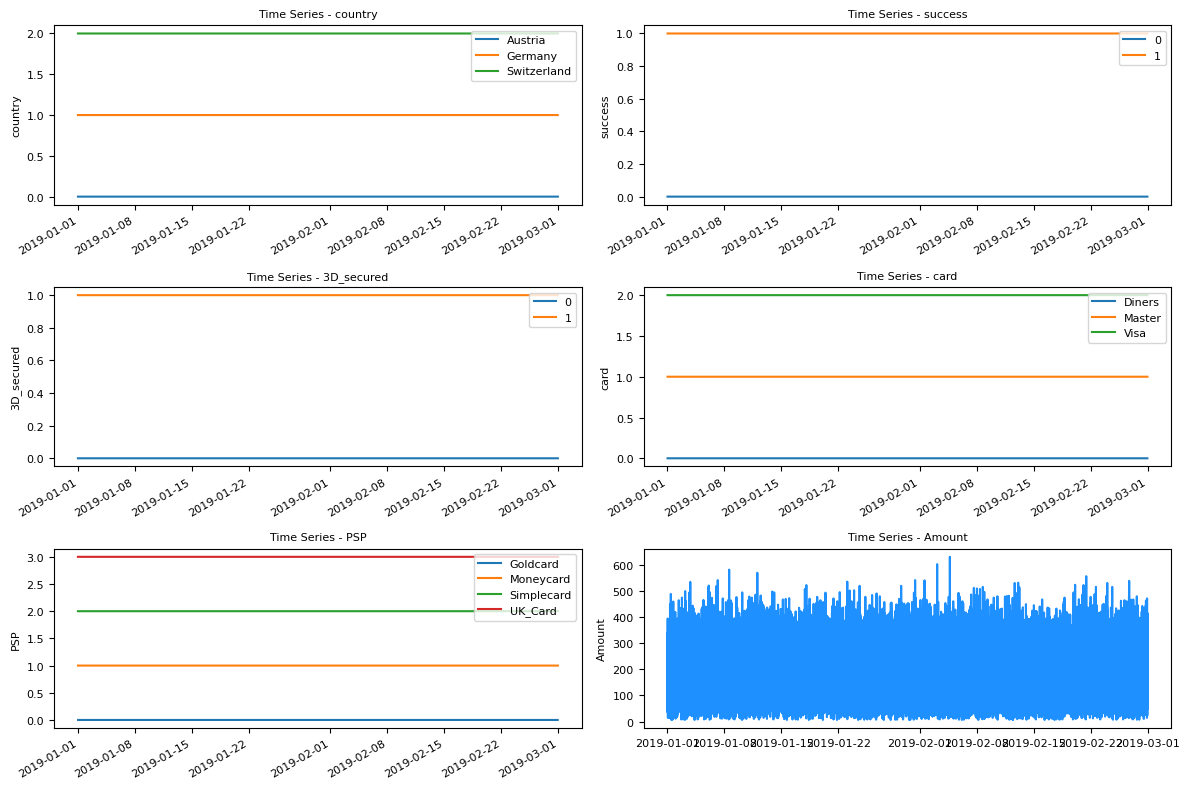

In [42]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
plot_against_time('country','country_num',0)
plot_against_time('success','success',1)
plot_against_time('3D_secured','3D_secured',2)
plot_against_time('card','card_num',3)
plot_against_time('PSP','PSP_num',4)
plot_against_time('amount','amount',5)
plt.tight_layout()
plt.show()

### Plot timeseries dummy date/time variables

#### Create dummy data/time features

In [43]:
## Create year of the day feature
dataset_time['year'] = dataset_time['tmsp'].dt.year
## Create hour of the day feature
dataset_time['month'] = dataset_time['tmsp'].dt.month_name()
## Create hour of the day feature
dataset_time['day_of_month'] = dataset_time['tmsp'].dt.day
## Create days of the week feature
dataset_time['day_of_week'] = dataset_time['tmsp'].dt.day_name()
## Create hour of the day feature
dataset_time['hour'] = dataset_time['tmsp'].dt.hour

In [44]:
dataset_time.head(1)

tmsp  country  amount  success      PSP  3D_secured  card  \
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa   

   time_delta  tx_number  date_order  country_num  card_num  PSP_num  year  \
0         0.0          0           0            1         2        3  2019   

     month  day_of_month day_of_week  hour  
0  January             1     Tuesday     0

### Plot variables based on time series dummy time variables

In [45]:
class Time_Series_Dummy_Visualizations():
    '''
    create visualization using the dummy time variables
    '''

    def count_sum_bar_cat(self, df_, feature, time_series_dummy, additional_feature=None, number_of_categories=None, label=False, ordered_list=None,
                          v_nrows=1, v_ncols=2, v_figsize=(15, 5)):
        '''
        # plot time dummy against feature with count and sum
        '''
        df = df_
        
        if additional_feature==None:
            # plot year against amount
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            df_count = df.groupby([time_series_dummy])[feature].count().reset_index()
            ax[0] = sns.barplot(x=df_count[time_series_dummy], y=df_count[feature], color='dodgerblue', ax=ax[0])
            ax[0].set_title("Count of amount")
            ax[0].set_ylabel('Count of Amount')
            if label==True:
                ax[0].bar_label(ax[0].containers[0])
            
            df_sum = df.groupby([time_series_dummy])[feature].sum().reset_index()
            ax[1] = sns.barplot(x=df_sum[time_series_dummy], y=df_sum[feature], color='dodgerblue', ax=ax[1])
            ax[1].set_title("Sum of amount")
            ax[1].set_ylabel('Sum of Amount')
            if label==True:
                ax[1].bar_label(ax[1].containers[0])
            plt.tight_layout()
            plt.show()
        else:
            # plot year against another feature based on amount
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            df_count = df.groupby([time_series_dummy,feature])[additional_feature].count().reset_index()
            ax[0]= sns.barplot(x=df_count [time_series_dummy], y=df_count[additional_feature], hue=df_count[feature], ax=ax[0], order=ordered_list)
            for i in range(number_of_categories):
                ax[0].bar_label(ax[0].containers[i])
            ax[0].set_ylabel('Count of Amount')
            ax[0].set_title("Count of amount")
            
            df_sum = df.groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
            ax[1]= sns.barplot(x=df_sum[time_series_dummy], y=df_sum[additional_feature], hue=df_sum[feature], ax=ax[1], order=ordered_list)
            for i in range(number_of_categories):
                ax[1].bar_label(ax[1].containers[i])
            ax[1].set_ylabel('Sum of Amount')
            ax[1].set_title("Sum of amount")
            plt.tight_layout()
            plt.show()

    def count_sum_pie_chart(self, df_, feature, nrows=2, ncols=3, v_figsize=(15, 5)):
        '''
        plot pie chart
        '''
        df = df_
        categories = df.groupby([feature]).count().reset_index()[feature].values.tolist()
        df_jan = df[df['month']=='January']
        categories_jan = df_jan.groupby([feature]).count().reset_index()[feature].values.tolist()
        df_feb = df[df['month']=='February']
        categories_feb = df_jan.groupby([feature]).count().reset_index()[feature].values.tolist()
        
        f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=v_figsize)
        # piechart count full year
        ax[0,0].pie(df.groupby(feature)[feature].count(), startangle=90, autopct='%.1f', labels=categories)
        ax[0,0].set_title("Pie chart count - Full year")

        # piechart count January
        ax[0,1].pie(df_jan.groupby(feature)[feature].count(), startangle=90, autopct='%.1f', labels=categories_jan)
        ax[0,1].set_title("Pie chart count - January")

        # piechart count February
        ax[0,2].pie(df_jan.groupby(feature)[feature].count(), startangle=90, autopct='%.1f', labels=categories_feb)
        ax[0,2].set_title("Pie chart count - February")

        # piechart amount full year
        ax[1,0].pie(df.groupby(feature)['amount'].sum(), startangle=90, autopct='%.1f', labels=categories)
        ax[1,0].set_title("Pie chart amount - Full year")

        # piechart amount January
        ax[1,1].pie(df_jan.groupby(feature)['amount'].sum(), startangle=90, autopct='%.1f', labels=categories_jan)
        ax[1,1].set_title("Pie chart amount - January")

        # piechart amount February
        ax[1,2].pie(df_jan.groupby(feature)['amount'].sum(), startangle=90, autopct='%.1f', labels=categories_feb)
        ax[1,2].set_title("Pie chart amount - February")


    def count_sum_line_cat(self, df_, feature, time_series_dummy, additional_feature=None, monthly_breakdown=False, country_choice=None, 
                           color='dodgerblue', month_list_ordered=['January', 'February'], v_nrows=1, v_ncols=2, v_figsize=(15, 5)):
        '''
        # plot time dummy against feature with count and sum
        '''

        if country_choice==None:
            df = df_
        else:
            df = df_[df_['country']==country_choice].copy()

        if monthly_breakdown==False:
            # plot day of month against country with count and sum
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            df_count = df.groupby([time_series_dummy, feature])[additional_feature].count().reset_index()
            ax[0]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[0], data=df_count, hue=feature)
            ax[0].legend(loc='upper right', fontsize=8)
            ax[0].set_ylabel('Count of Amount')
            ax[0].set_title("Count of amount")
            
            df_sum = df.groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
            ax[1]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[1], data=df_sum, hue=feature)
            ax[1].set_title("Sum of amount")
            ax[1].legend(loc='upper right')
            ax[1].set_ylabel('Sum of Amount')
            plt.tight_layout()
            plt.show()
        else:
            # plot day of month against country with count - separated by month
            df_count = df.groupby(['month',time_series_dummy,feature])[additional_feature].count().reset_index()
            df_count.month = pd.Categorical(df_count.month, categories=month_list_ordered, ordered=True)
            df_count = df_count.sort_values(['month'])
            g = sns.FacetGrid(data=df_count, col='month', sharex=False, sharey=False, height=4, aspect=2)
            g.map_dataframe(sns.lineplot, x=time_series_dummy, y=additional_feature, hue= feature)
            g.axes[0,0].set_ylabel('Count of Amount')

            # plot day of month against country with sum - separated by month
            df_sum = df.groupby(['month',time_series_dummy,
                                                           feature])[additional_feature].sum().reset_index()
            df_sum.month = pd.Categorical(df_sum.month, categories=month_list_ordered, ordered=True)
            df_sum = df_sum.sort_values(['month'])
            g = sns.FacetGrid(data=df_sum, col='month', sharex=False, sharey=False, height=4, aspect=2)
            g.map_dataframe(sns.lineplot, x=time_series_dummy, y=additional_feature, hue=feature)
            g.axes[0,0].set_ylabel('Sum of Amount')
            plt.tight_layout()
            plt.show()

    def count_sum_barstackedbar_cat(self, df_, feature, time_series_dummy, monthly_breakdown=False, ordered=False, ordered_list=None, label=False, 
                                    month_list=['January', 'February'], additional_feature=None, color='dodgerblue', color_list=None, 
                                    v_nrows=1, v_ncols=2, v_figsize=(15, 5)):
        ''',
        # plot stacked bar chart
        '''
        df = df_
        if monthly_breakdown==False:
            # plot day of month by with with amount count
            if additional_feature==None:
                # plot month against amount
                f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                df_count = dataset_time.groupby([time_series_dummy])[feature].count().reset_index()
                df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                df_count = df_count.sort_values([time_series_dummy])
                ax[0] = sns.barplot(x=df_count[time_series_dummy], y=df_count[feature], color=color,  ax=ax[0])
                if label==True:
                    ax[0].bar_label(ax[0].containers[0])
                ax[0].set_ylabel('Count of Amount')
                if feature!='amount':
                    ax[0].legend(loc='upper right', fontsize=8)
                
                df_sum = dataset_time.groupby([time_series_dummy])[feature].sum().reset_index()
                df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                df_sum = df_sum.sort_values([time_series_dummy])
                ax[1] = sns.barplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color,  ax=ax[1])
                ax[1].set_ylabel('Count of Amount')
                if label==True:
                    ax[1].bar_label(ax[1].containers[0])
                if feature!='amount':
                    ax[1].legend(loc='upper right', fontsize=8)
                plt.tight_layout()
                plt.show()
            else:
                f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                df_count = df.groupby([time_series_dummy,feature])[additional_feature].count().reset_index()
                if ordered==True:
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count =df_sum.sort_values([time_series_dummy])
                pivot = pd.pivot_table(data=df_count, index=[time_series_dummy], columns=[feature], values=additional_feature) 
                ax[0] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[0])
                ax[0].set_title('Count of amount', fontsize=8)
                if feature!='amount':
                    ax[0].legend(loc='upper right', fontsize=8)
                
                df_sum = dataset_time.groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
                if ordered==True:
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                    df_sum = df_sum.sort_values([time_series_dummy])
                pivot = pd.pivot_table(data=df_sum, index=[time_series_dummy], columns=[feature], values=additional_feature) 
                ax[1] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[1])
                ax[1].set_title('Sum of amount', fontsize=8)
                if feature!='amount':
                    ax[1].legend(loc='upper right', fontsize=8)
                plt.tight_layout()
                plt.show()
        else:
            # plot day of month against country with count - bar graph
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            for month in month_list:
                df_count = df[df['month']==month].groupby([time_series_dummy,feature])[additional_feature].count().reset_index()
                if ordered==True:
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count =df_sum.sort_values([time_series_dummy])
                pivot = pd.pivot_table(data=df_count, index=[time_series_dummy], columns=[feature], values=additional_feature) 
                if month_list.index(month)==0:
                    ax[0,0] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[0,0])
                    ax[0,0].set_title('Count of amount - {}'.format(month), fontsize=8)
                    ax[0,0].legend(loc='upper right', fontsize=8)
                else:
                    ax[0,1] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[0,1])
                    ax[0,1].set_title('Count of amount - {}'.format(month), fontsize=8)
                    ax[0,1].legend(loc='upper right', fontsize=8)

            # plot day of month against country with sum - bar graph
            for month in month_list:
                df_sum = df[df['month']==month].groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
                if ordered==True:
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                pivot = pd.pivot_table(data=df_sum, index=[time_series_dummy], columns=feature, values=additional_feature) 
                if month_list.index(month)==0:
                    ax[1,0] = pivot.plot.bar(stacked=True, color =color_list, ax=ax[1,0])
                    ax[1,0].set_title('Sum of amount - {}'.format(month), fontsize=8)
                    ax[1,0].legend(loc='upper right', fontsize=8)
                else:
                    ax[1,1] = pivot.plot.bar(stacked=True, color =color_list, ax=ax[1,1])
                    ax[1,1].set_title('Sum of amount - {}'.format(month), fontsize=8)
                    ax[1,1].legend(loc='upper right', fontsize=8)
            plt.tight_layout()
            plt.show()

    def line_ordered(self, df_, feature, time_series_dummy, ordered_list, additional_feature=None, monthly_breakdown=False, country_choice=None, 
                     month_list=['January', 'February'], color='dodgerblue', v_nrows=1, v_ncols=2, v_figsize=(15, 5), v_ylim=0):
        if country_choice==None:
            df = df_
        else:
            df = df_[df_['country']==country_choice].copy()
            
        if monthly_breakdown == False:
            # plot day of month against country with sum (All) - separated by month
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            df_count = df.groupby([time_series_dummy,feature])[additional_feature].count().reset_index()
            df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
            df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
            df_count = df_count.sort_values([time_series_dummy])
            ax[0]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[0], color= color,data=df_count, hue=feature)
            ax[0].legend(loc='upper right', fontsize=8)
            ax[0].set_title("Count of amount")
            
            df_sum = df.groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
            df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
            df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
            df_sum = df_sum.sort_values([time_series_dummy])
            ax[1]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[1], data=df_sum, hue=feature)
            ax[1].set_title("Sum of amount")
            ax[1].legend(loc='upper right', fontsize=8)
            ax[1].set_xlim(v_ylim,None)
            plt.tight_layout()
            plt.show()
        else:
            f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
            for month in month_list:
                df_count = df[df['month']==month].groupby([time_series_dummy,feature])[additional_feature].count().reset_index()
                df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
                df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                df_count =df_count.sort_values([time_series_dummy])
                if month_list.index(month)==0:
                    ax[0,0]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[0,0], hue=feature, data=df_count)
                    ax[0,0].set_title("Count of amount-{}".format(month),fontsize=8)
                    ax[0,0].legend(loc='upper right', fontsize=8)
                    ax[0,0].set_ylabel('Sum of Amount')
                else:
                    ax[0,1]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[0,1], hue=feature, data=df_count)
                    ax[0,1].set_title("Count of amount-{}".format(month),fontsize=8)
                    ax[0,1].legend(loc='upper right', fontsize=8)
                    ax[0,1].set_ylabel('')

            for month in month_list:
                df_sum = df[df['month']==month].groupby([time_series_dummy,feature])[additional_feature].sum().reset_index()
                df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
                df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories= ordered_list, ordered=True)
                df_sum = df_sum.sort_values([time_series_dummy])
                if month_list.index(month)==0:
                    ax[1,0]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[1,0], hue=feature, data=df_sum)
                    ax[1,0].set_title("Sum of amount-{}".format(month),fontsize=8)
                    ax[1,0].legend(loc='upper right', fontsize=8)
                    ax[1,0].set_ylabel('Sum of Amount')
                else:
                    ax[1,1]= sns.lineplot(x=time_series_dummy, y=additional_feature, ax=ax[1,1], hue=feature, data=df_sum)
                    ax[1,1].set_title("Sum of amount-{}".format(month),fontsize=8)
                    ax[1,1].legend(loc='upper right', fontsize=8)
                    ax[1,1].set_ylabel('')
            plt.tight_layout()
            plt.show()

    def line_bar_line_graph(self, df_, feature, time_series_dummy, line_only=False, ordered_list=None, monthly_breakdown=False, label=False, v_ylim=0,
                            color1='dodgerblue', color2='red', month_list_ordered=['January', 'February'], v_nrows=2, v_ncols=1, v_figsize=(15, 5)):
        df = df_
        if line_only == False:
            if ordered_list==None:
                if monthly_breakdown == False:
                    # plot month against amount - bar
                    f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                    df_count = df.groupby([time_series_dummy])[feature].count().reset_index()
                    ax[0] = sns.barplot(x=df_count[time_series_dummy], y=df_count[feature], color=color1, ax=ax[0])
                    ax[0] = sns.lineplot(x=df_count[time_series_dummy], y=df_count[feature], color=color2, ax=ax[0])
                    ax[0].set_ylabel('Count of Amount')
                    
                    df_sum = df.groupby([time_series_dummy])[feature].sum().reset_index()
                    ax[1] = sns.barplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color1, ax=ax[1])
                    ax[1] = sns.lineplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color2, ax=ax[1])
                    ax[1].set_ylabel('Sum of Amount')
                    plt.tight_layout()
                    plt.show()
                else:
                    # plot day of the month against amount disaggregated by month - bar
                    df_count = df.groupby(['month', time_series_dummy])[feature].count().reset_index()
                    df_count.month = pd.Categorical(df_count.month, categories=month_list_ordered, ordered=True)
                    df_count = df_count.sort_values([time_series_dummy])
                    g = sns.FacetGrid(data=df_count, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.barplot, x=time_series_dummy, y=feature, color=color1)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color2)
                    g.axes[0,0].set_ylabel('Count of Amount')
                    
                    df_sum = df.groupby(['month', time_series_dummy])[feature].sum().reset_index()
                    df_sum.month = pd.Categorical(df_sum.month, categories=month_list_ordered, ordered=True)
                    df_sum = df_sum.sort_values(['month'])
                    g = sns.FacetGrid(data=df_sum, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.barplot, x=time_series_dummy, y=feature, color=color1)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color2)
                    g.axes[0,0].set_ylabel('Sum of Amount')
                    plt.tight_layout()
                    plt.show()
            else:
                if monthly_breakdown==False:
                    # plot day_of_week amount - bar
                    f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                    df_count = df.groupby([time_series_dummy])[feature].count().reset_index()
                    df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count = df_count.sort_values(time_series_dummy)
                    sns.barplot(x=df_count[time_series_dummy], y=df_count[feature], color=color1, ax=ax[0])
                    sns.lineplot(x=df_count[time_series_dummy], y=df_count[feature], color=color2, ax=ax[0])
                    if label==True:
                        ax[0].bar_label(ax[0].containers[0])
                    ax[0].set_title("Sum of amount")
                    ax[0].set_ylabel('Count of Amount')
                    
                    df_sum = df.groupby([time_series_dummy])[feature].sum().reset_index()
                    df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                    df_sum = df_sum.sort_values(time_series_dummy)
                    sns.barplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color1, ax=ax[1])
                    sns.lineplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color2, ax=ax[1])
                    if label==True:
                        ax[1].bar_label(ax[1].containers[0])
                    ax[1].set_title("Sum of amount")
                    ax[1].set_ylabel('Sum of Amount')
                    plt.tight_layout()
                    plt.show()
                else:
                    # plot day of the week against amount disaggregated by month - bar
                    df_count = df.groupby(['month', time_series_dummy])[feature].count().reset_index()
                    df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count.month = pd.Categorical(df_count.month, categories=month_list_ordered, ordered=True)
                    df_count = df_count.sort_values(['month', time_series_dummy])
                    g = sns.FacetGrid(data=df_count, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.barplot, x=time_series_dummy, y=feature, color=color1)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color2)
                    g.axes[0,0].set_ylabel('Count of Amount')

                    df_sum = df.groupby(['month', time_series_dummy])[feature].sum().reset_index()
                    df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                    df_sum.month = pd.Categorical(df_sum.month, categories=month_list_ordered, ordered=True)
                    df_sum = df_sum.sort_values(['month', time_series_dummy])
                    g = sns.FacetGrid(data=df_sum, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.barplot, x=time_series_dummy, y=feature, color=color1)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color2)
                    g.axes[0,0].set_ylabel('Sum of Amount')
                    plt.show()
        else:
            if ordered_list==None:
                if monthly_breakdown == False:
                    # plot month against amount - line
                    f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                    df_count = df.groupby([time_series_dummy])[feature].count().reset_index()
                    ax[0] = sns.lineplot(x=df_count[time_series_dummy], y=df_count[feature], color=color1, ax=ax[0])
                    ax[0].set_ylabel('Count of Amount')
                    
                    df_sum = dataset_time.groupby([time_series_dummy])[feature].sum().reset_index()
                    ax[1] = sns.lineplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color1, ax=ax[1])
                    ax[1].set_ylabel('Sum of Amount')
                    plt.tight_layout()
                    plt.show()
                else:
                    # plot day of the month against amount disaggregated by month - line
                    df_count = df.groupby(['month', time_series_dummy])[feature].count().reset_index()
                    df_count.month = pd.Categorical(df_count.month, categories=month_list_ordered, ordered=True)
                    df_count = df_count.sort_values(['month'])
                    g = sns.FacetGrid(data=df_count, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color1)
                    g.axes[0,0].set_ylabel('Count of Amount')
                    g.set(ylim=(v_ylim,None))

                    df_sum = df.groupby(['month', time_series_dummy])[feature].sum().reset_index()
                    df_sum.month = pd.Categorical(df_sum.month, categories=month_list_ordered, ordered=True)
                    df_sum = df_sum.sort_values(['month'])
                    g = sns.FacetGrid(data=df_sum, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color1)
                    g.axes[0,0].set_ylabel('Sum of Amount')
                    g.set(ylim=(v_ylim,None))
                    plt.tight_layout()
                    plt.show()
            else:
                if monthly_breakdown==False:
                    # plot day_of_week amount - line
                    f, ax = plt.subplots(nrows=v_nrows, ncols=v_ncols, figsize=v_figsize)
                    df_count = df.groupby([time_series_dummy])[feature].count().reset_index()
                    df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count = df_count.sort_values(time_series_dummy)
                    sns.lineplot(x=df_count[time_series_dummy], y=df_count[feature], color=color1, ax=ax[0])
                    ax[0].set_title("Count of amount")
                    ax[0].set_ylabel('Count of Amount')
                    
                    df_sum = df.groupby([time_series_dummy])[feature].sum().reset_index()
                    df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                    df_sum = df_sum.sort_values(time_series_dummy)
                    sns.lineplot(x=df_sum[time_series_dummy], y=df_sum[feature], color=color1, ax=ax[1])
                    ax[1].set_title("Sum of amount")
                    ax[1].set_ylabel('Count of Amount')
                    plt.ylim(v_ylim,None)
                    plt.tight_layout()
                    plt.show()
                else:
                    # plot time series value against amount disaggregated by month - bar
                    df_count = df.groupby(['month', time_series_dummy])[feature].count().reset_index()
                    df_count[time_series_dummy] = df_count[time_series_dummy].astype(str)
                    df_count[time_series_dummy] = pd.Categorical(df_count[time_series_dummy], categories=ordered_list, ordered=True)
                    df_count.month = pd.Categorical(df_count.month, categories=month_list_ordered, ordered=True)
                    df_count = df_count.sort_values(['month',time_series_dummy])
                    g = sns.FacetGrid(data=df_count, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color1)
                    g.axes[0,0].set_ylabel('Count of Amount')
                    
                    df_sum = df.groupby(['month', time_series_dummy])[feature].sum().reset_index()
                    df_sum[time_series_dummy] = df_sum[time_series_dummy].astype(str)
                    df_sum[time_series_dummy] = pd.Categorical(df_sum[time_series_dummy], categories=ordered_list, ordered=True)
                    df_sum.month = pd.Categorical(df_sum.month, categories=month_list_ordered, ordered=True)
                    df_sum = df_sum.sort_values(['month', time_series_dummy])
                    g = sns.FacetGrid(data=df_sum, col='month', sharex=False, sharey=False, height=4, aspect=2)
                    g.map_dataframe(sns.lineplot, x=time_series_dummy, y=feature, color=color1)
                    g.set(ylim=(v_ylim,None))
                    g.axes[0,0].set_ylabel('Sum of Amount')
                    plt.tight_layout()
                    plt.show()

#### Plot amount against dummy time variables

In [46]:
TimeSeries_VisualizationTool = Time_Series_Dummy_Visualizations()

In [47]:
def plot_numeric_features(numeric_feature):
    # plot year against amount
    print("Year against {}".format(numeric_feature))
    TimeSeries_VisualizationTool.count_sum_bar_cat(dataset_time, numeric_feature,'year', v_figsize=(15, 3),label=True)

    # plot month against amount
    print("Month against {}".format(numeric_feature))
    TimeSeries_VisualizationTool.count_sum_barstackedbar_cat(dataset_time, numeric_feature, 'month',ordered_list=['January', 'February'], label=True, 
                                                             color='dodgerblue', v_figsize=(15, 3))

    # plot day of month against amount - bar
    print("Day_of_month against {} - bar".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_month')

    # plot day of month against amount - line
    print("Day_of_month against {} - line".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_month', line_only=True)

    # plot day of the month against amount disaggregated by month - line
    print("Day_of_month against {} disaggregated by month".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_month', line_only=True, monthly_breakdown=True)

    # plot day_of_week amount - bar
    print("Day_of_week against {} - bar".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_week', v_nrows=1, v_ncols=2, v_figsize=(15, 3), label=True,
                                                     ordered_list=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # plot day_of_week amount - line
    print("Day_of_week against {} - line".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_week', line_only=True, v_nrows=1, v_ncols=2, v_figsize=(15, 3), 
                                                     v_ylim=800000, 
                                                     ordered_list=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # plot day of the week against amount disaggregated by month - bar
    print("Day_of_week against {} disaggregated by month - bar".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_week', monthly_breakdown=True, v_nrows=1, v_ncols=2, v_figsize=(15, 3),
                                                     ordered_list=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # plot day of the week against amount disaggregated by month - line
    print("Day_of_week against {} disaggregated by month - line".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'day_of_week', line_only=True, monthly_breakdown=True, v_ylim=200000, v_nrows=1,
                                                     v_ncols=2, v_figsize=(15, 3), 
                                                     ordered_list=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    # plot hour of day against amount - bar
    print("Hour against {} - bar".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'hour', v_nrows=2, v_ncols=1, v_figsize=(15, 5), 
                                                     ordered_list=['6','7','8','9','10','11','12','13', '14','15', '16','17','18','19','20','21','22',
                                                                   '23','0','1','2','3','4','5'])

    # plot hour of day against amount - line
    print("Hour against {} - line".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'hour',line_only=True, v_nrows=2, v_ncols=1, v_figsize=(15, 5), v_ylim=350000, 
                                                     ordered_list=['6','7','8','9','10','11','12','13', '14','15', '16','17','18','19','20','21','22',
                                                                   '23','0', '1','2','3','4','5'])

    # plot hours against amount disaggregated by month - bar
    print("Hour against {} disaggregated by month - bar".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'hour', monthly_breakdown=True, v_nrows=1, v_ncols=2, v_figsize=(15, 3), 
                                                     ordered_list=['6','7','8','9','10','11','12','13', '14','15', '16','17','18','19','20','21', '22', 
                                                                   '23','0','1','2','3','4','5'])

    # plot hours against amount disaggregated by month - line
    print("Hour against {} disaggregated by month - line".format(numeric_feature))
    TimeSeries_VisualizationTool.line_bar_line_graph(dataset_time, numeric_feature, 'hour', line_only=True, monthly_breakdown=True, v_ylim=170000, v_nrows=1, 
                                                     v_ncols=2, v_figsize=(15, 3), ordered_list=['6','7','8','9','10','11','12','13', '14','15', '16',
                                                                                                 '17','18','19','20','21','22', '23','0','1','2','3',
                                                                                                 '4','5'])

Year against amount


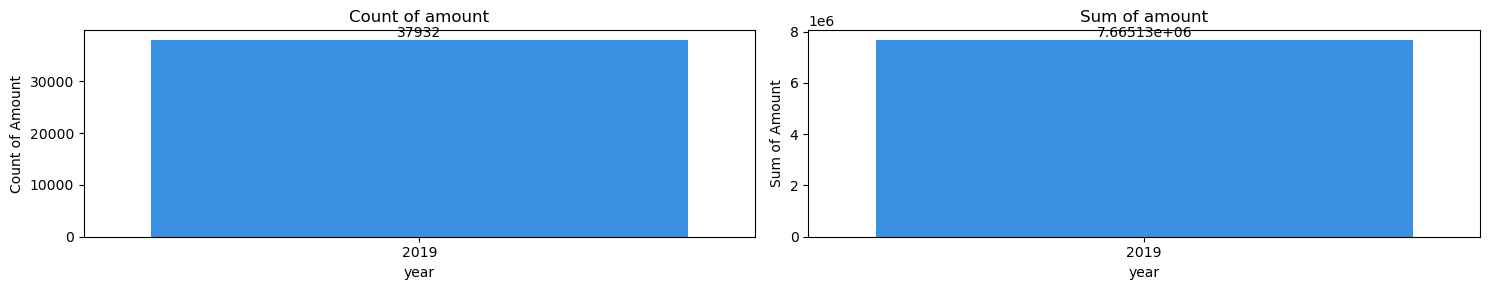

Month against amount


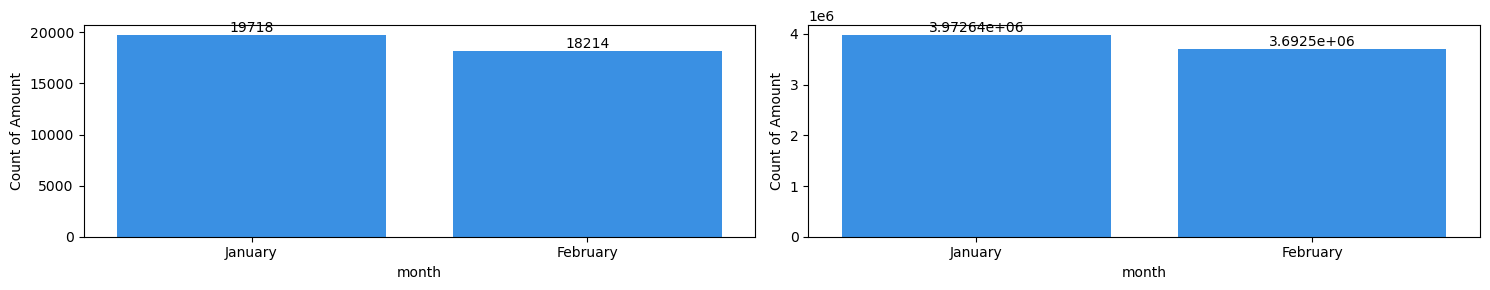

Day_of_month against amount - bar


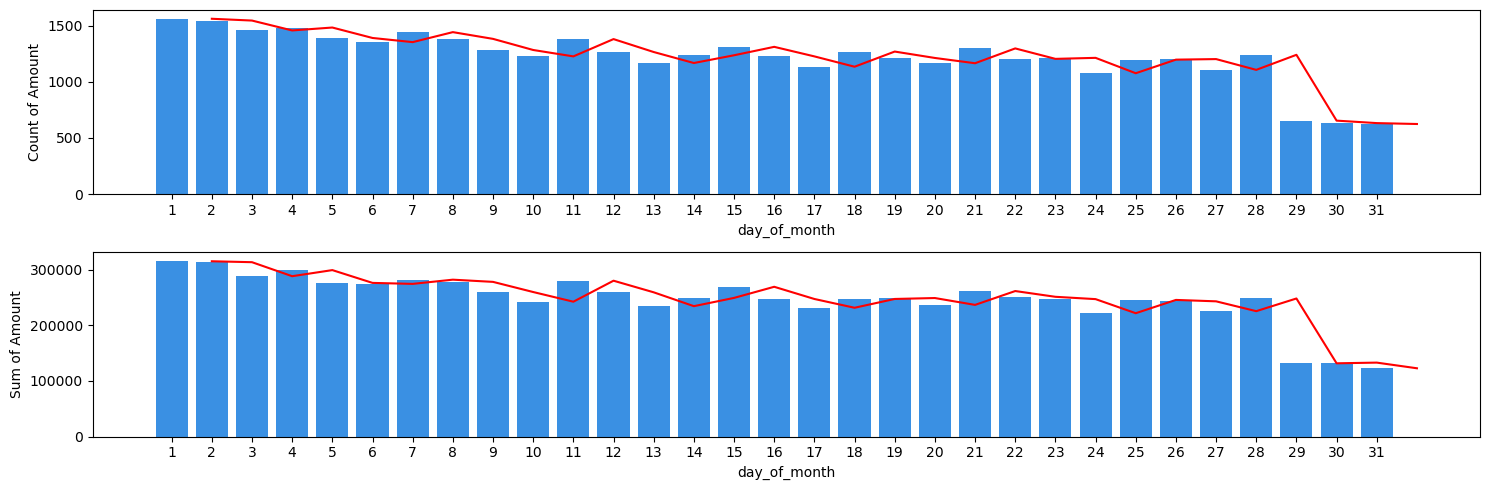

Day_of_month against amount - line


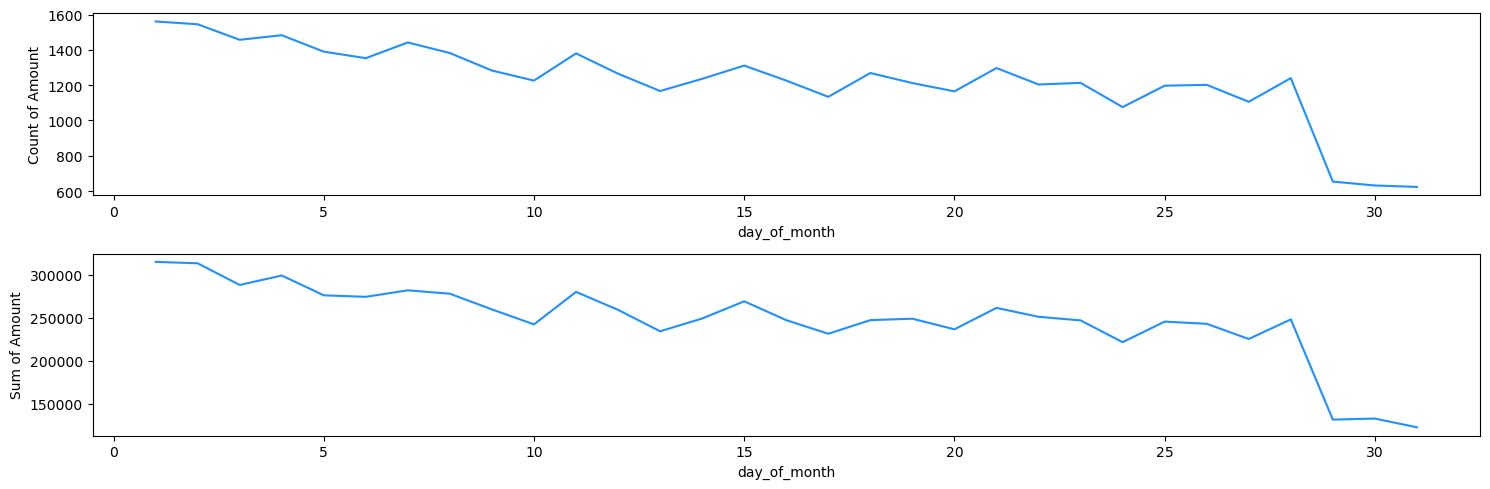

Day_of_month against amount disaggregated by month


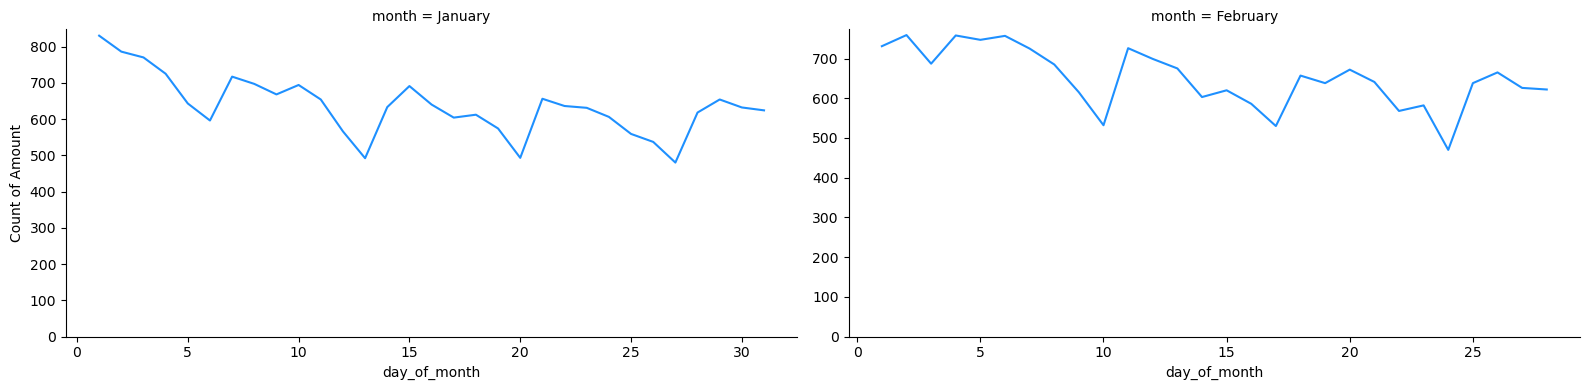

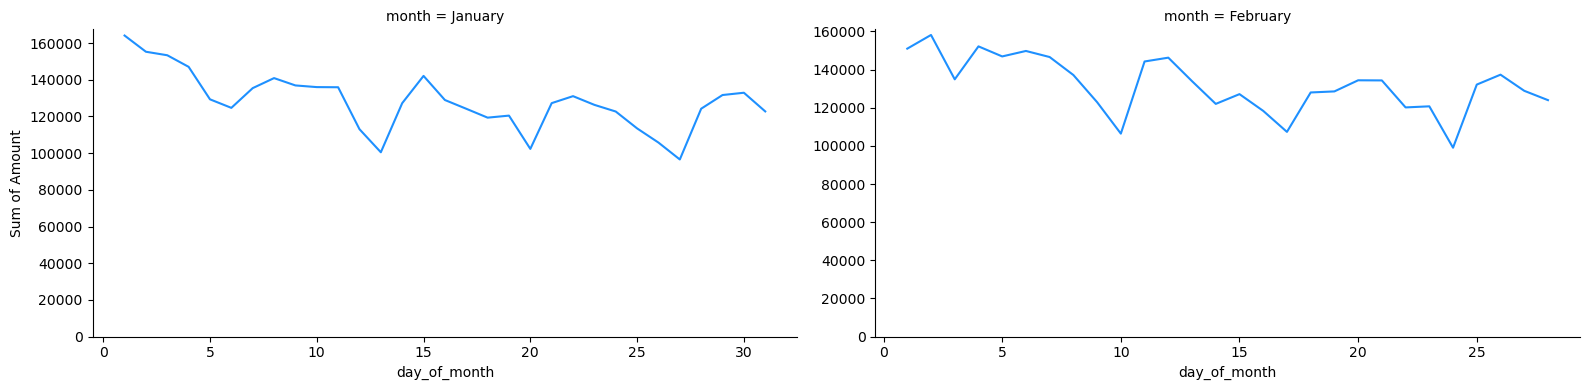

Day_of_week against amount - bar


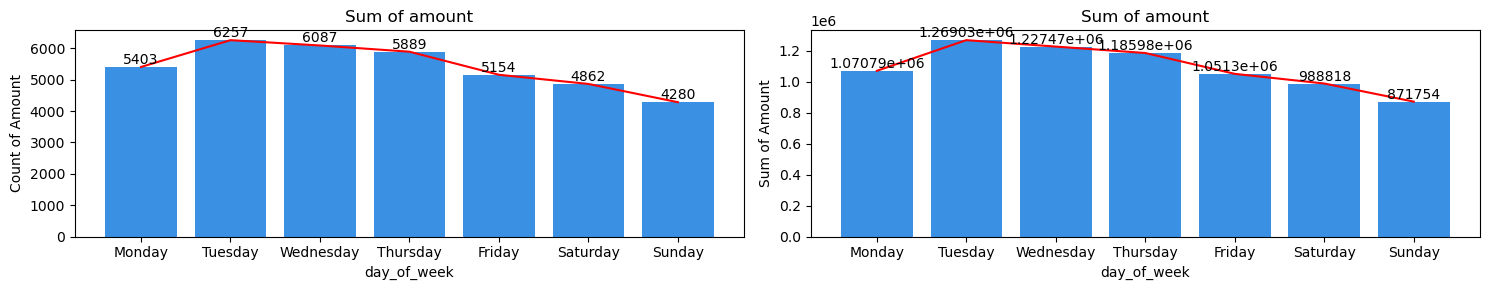

Day_of_week against amount - line


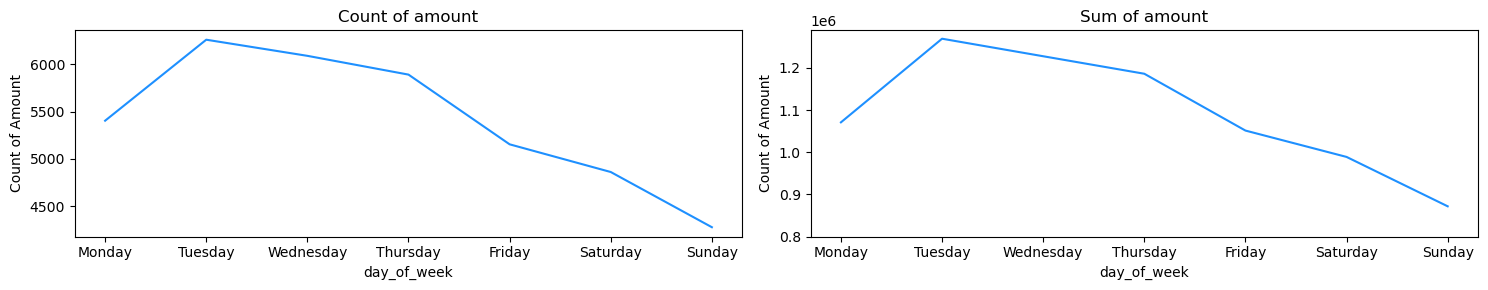

Day_of_week against amount disaggregated by month - bar


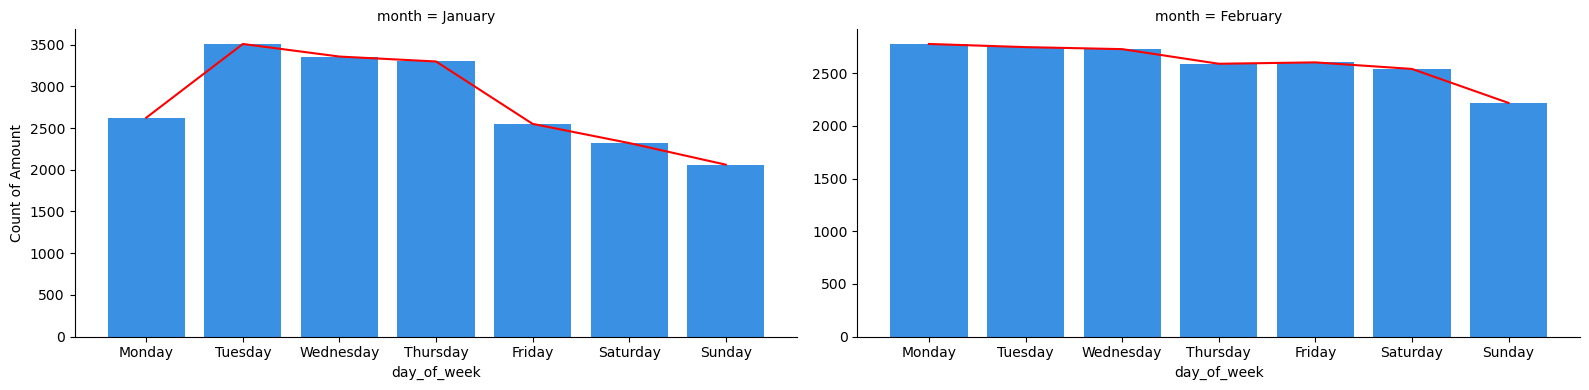

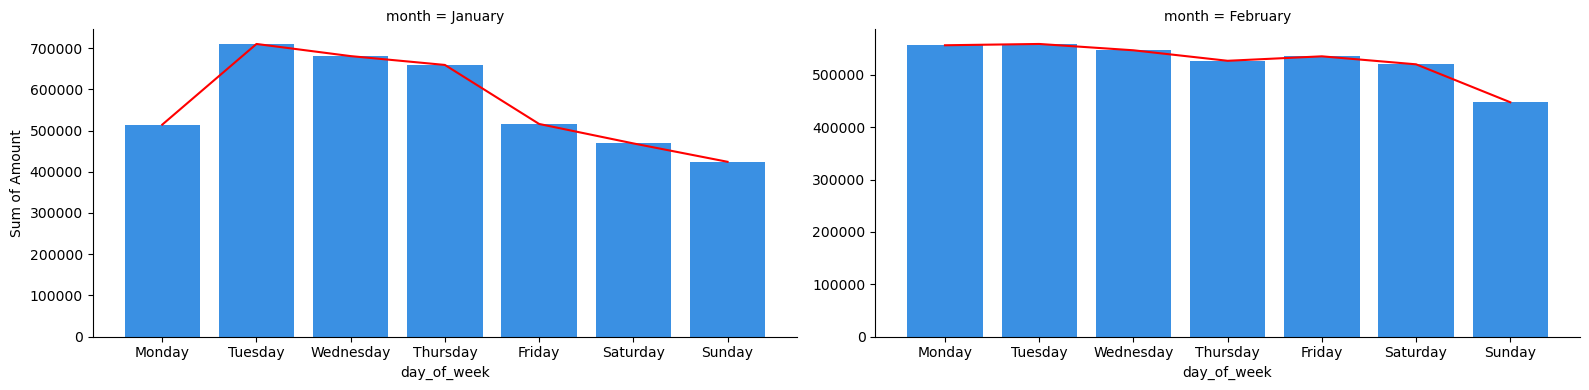

Day_of_week against amount disaggregated by month - line


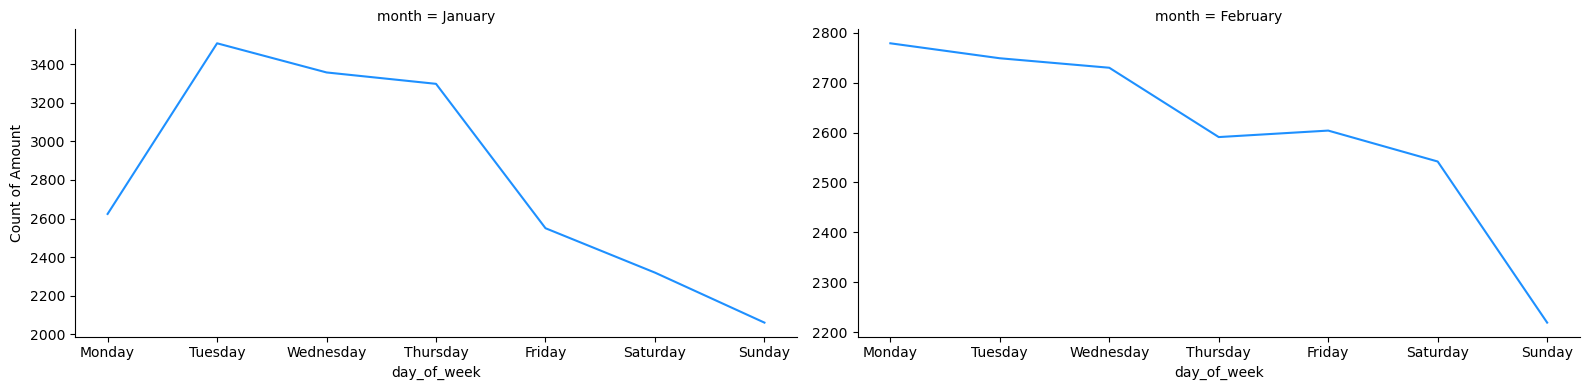

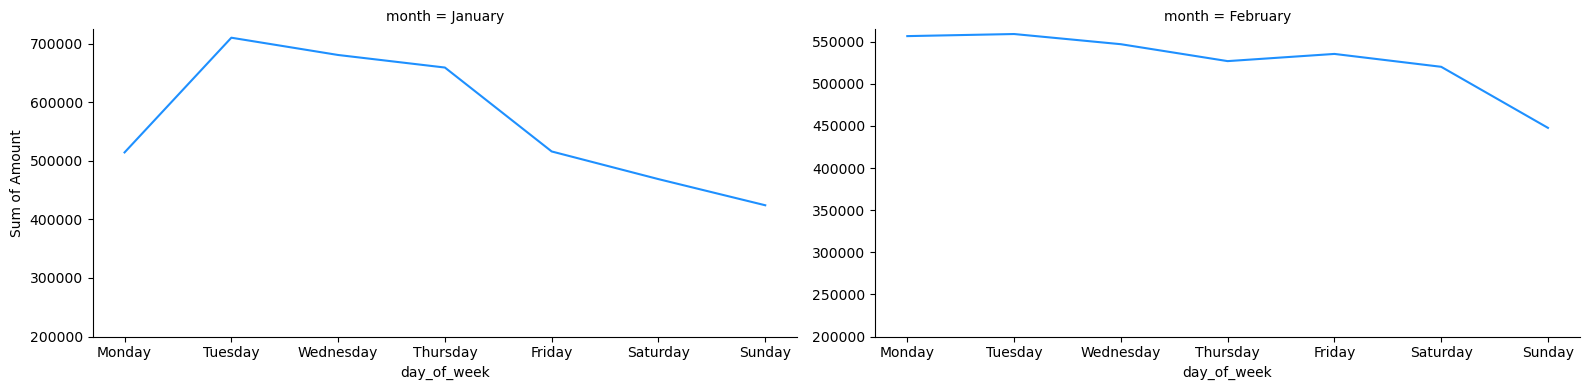

Hour against amount - bar


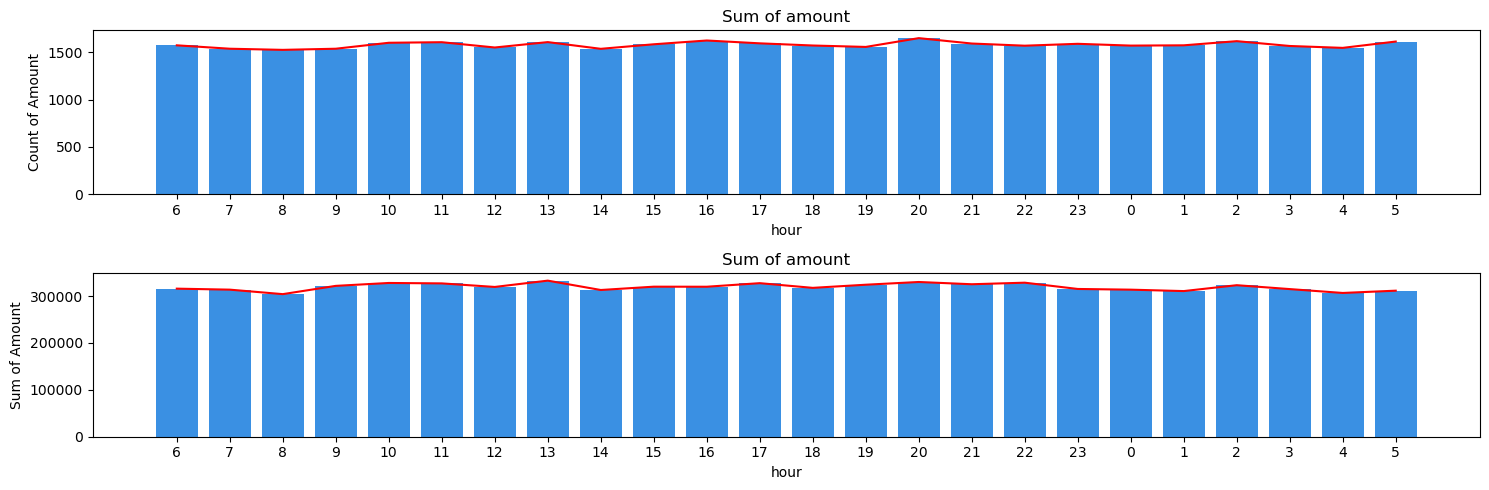

Hour against amount - line


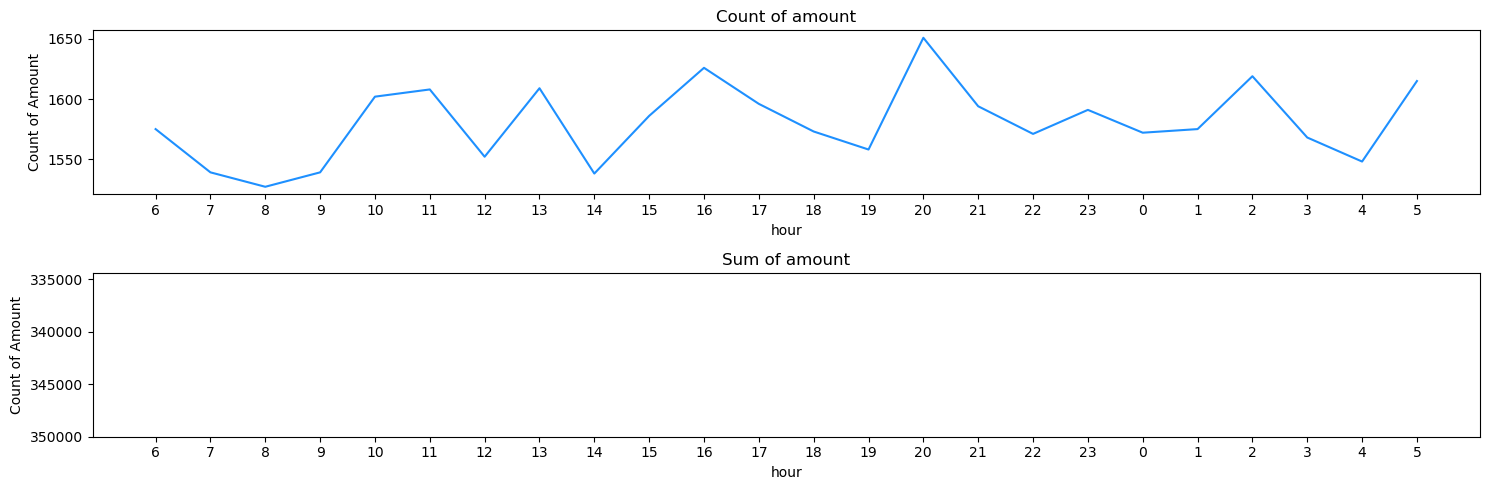

Hour against amount disaggregated by month - bar


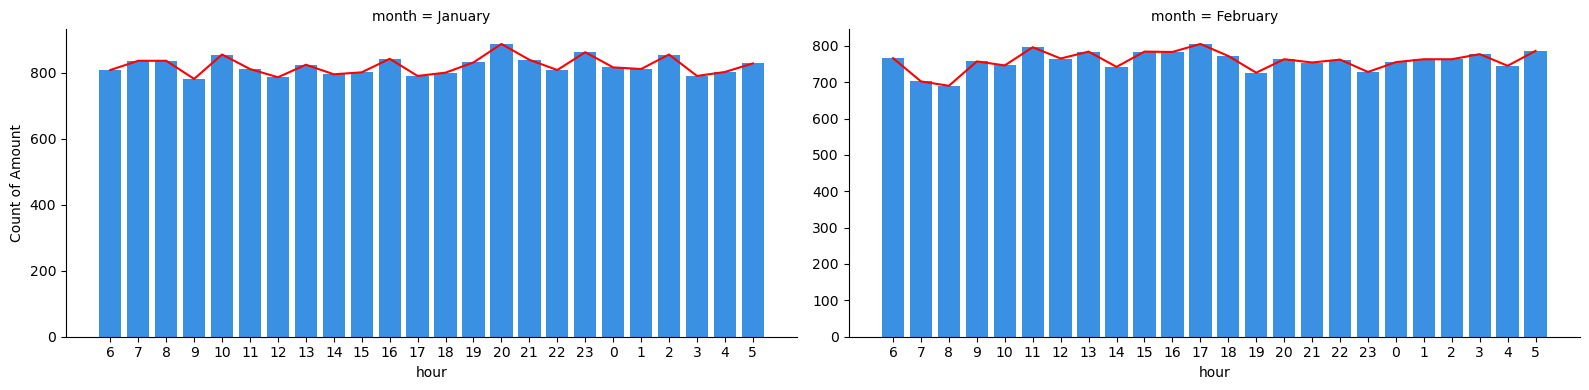

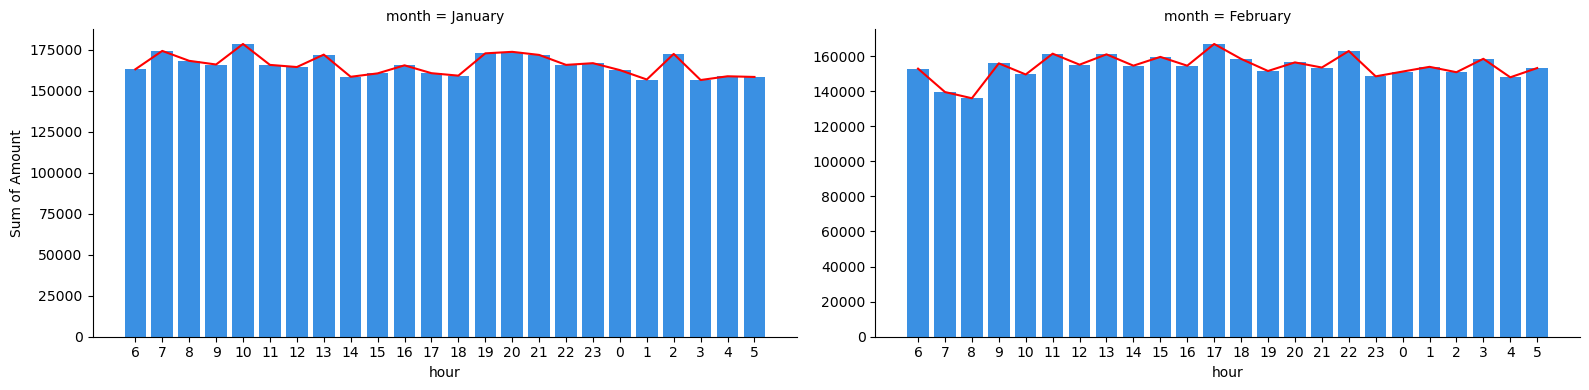

Hour against amount disaggregated by month - line


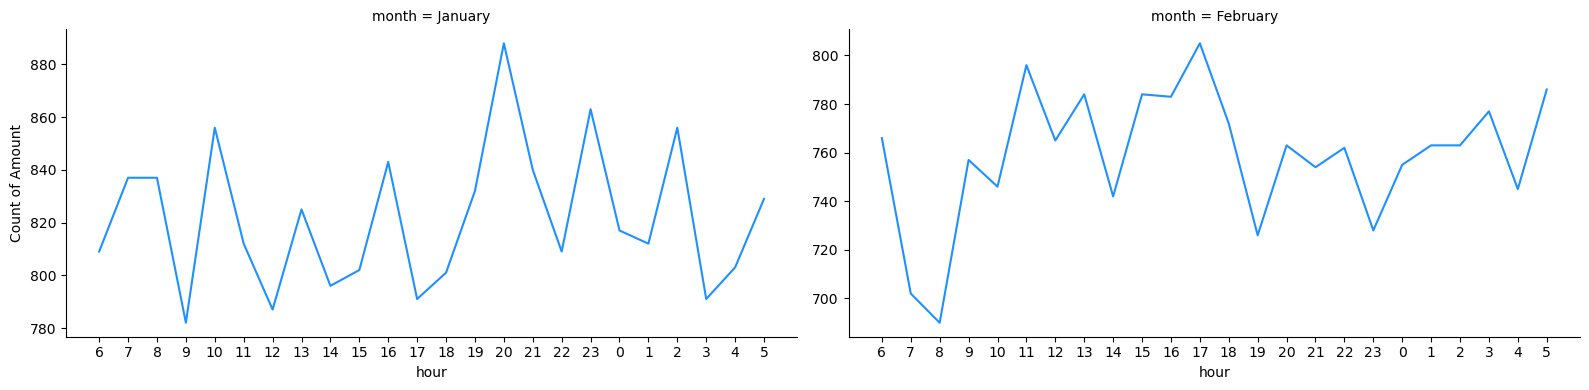

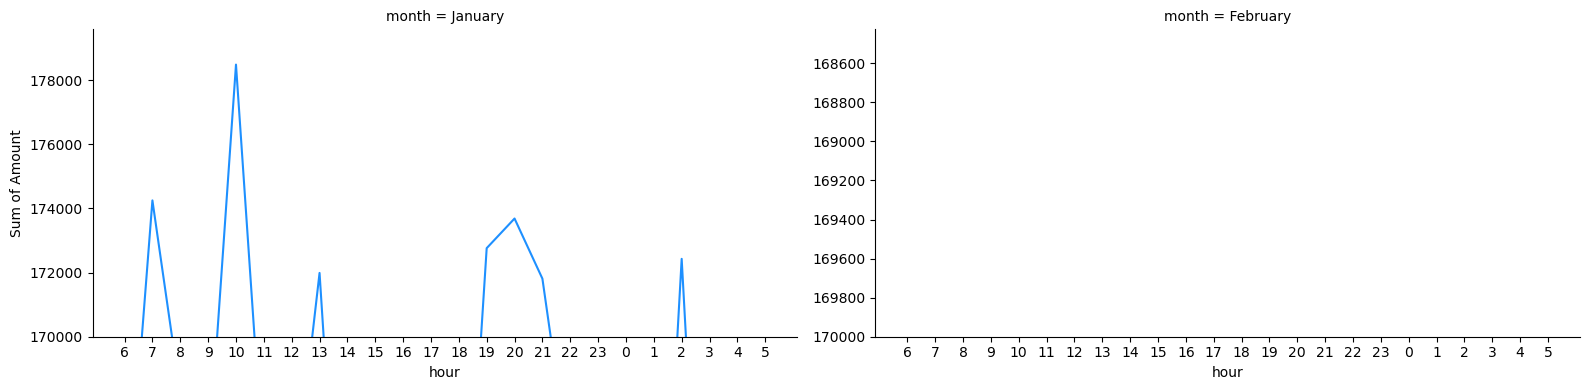

In [48]:
plot_numeric_features('amount')

### Plot categorical variables time series against dummy variables

In [49]:
def plot_categorical_features(dataset_time, cat_feature, color_list=['red', 'orange', 'green'], number_of_categories=3):
    #plot year against amount
    print("Year against amount by {}".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_bar_cat(dataset_time, cat_feature,'year', additional_feature='amount', v_figsize=(15, 4), 
                                                   number_of_categories=number_of_categories, label=True)

    # plot month against amount
    print("Month against amount by {}".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_bar_cat(dataset_time, cat_feature,'month', additional_feature='amount', ordered_list=['January', 'February'], 
                                                   v_figsize=(15, 4), number_of_categories=number_of_categories, label=True)

    # plot percentage distribution
    TimeSeries_VisualizationTool.count_sum_pie_chart(dataset_time, cat_feature)
    
    # plot day of month by with with amount count and sum
    print("Day_of_month against amount bar chart by {}".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_barstackedbar_cat(dataset_time, cat_feature, 'day_of_month', additional_feature='amount',  v_figsize=(12, 4),
                                                         color_list=color_list)

    # plot day of month against country with count and sum - bar graph separated by month
    print("Day_of_month against amount bar chart by {} - separated by month ".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_barstackedbar_cat(dataset_time, cat_feature, 'day_of_month', monthly_breakdown=True, additional_feature='amount', 
                                                         v_nrows=2, v_ncols=2, v_figsize=(12, 5), color_list=color_list)

    # plot day of month against country with count and sum
    print("Day_of_month against amount by {}".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_line_cat(dataset_time, cat_feature, 'day_of_month', additional_feature='amount', v_figsize=(12, 3))
                                                                                                                        
    # plot day of month against country with count and sum - separated by month
    print("Day_of_month against amount by {} separated by month".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_line_cat(dataset_time, cat_feature, 'day_of_month', monthly_breakdown=True, additional_feature='amount', 
                                                    v_figsize=(12, 3))

    for country in ['Austria', 'Germany', 'Switzerland']:
        # plot day of month against country with count and sum - country
        print("Day_of_month against amount for {}".format(country))
        TimeSeries_VisualizationTool.count_sum_line_cat(dataset_time, cat_feature, 'day_of_month', additional_feature='amount', country_choice=country, 
                                                        v_figsize=(12, 3))
    
        # plot day of month against country with count and sum (Only country) - separated by month
        print("Day_of_month against amount for {} separated by month".format(country))
        TimeSeries_VisualizationTool.count_sum_line_cat(dataset_time, cat_feature, 'day_of_month', monthly_breakdown=True, additional_feature='amount', 
                                                        country_choice=country,  v_figsize=(12, 3))

    # plot day of week against country with count and sum - bar
    print("Day_of_week against amount bar chart by {}".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_barstackedbar_cat(dataset_time, cat_feature, 'day_of_week', additional_feature='amount',  v_figsize=(13, 4), 
                                                             color_list=color_list)
    
    # plot day of week against country with count - by month
    print("Day_of_week against amount bar chart by {} - separated by month ".format(cat_feature))
    TimeSeries_VisualizationTool.count_sum_barstackedbar_cat(dataset_time, cat_feature, 'day_of_week', monthly_breakdown=True, additional_feature='amount', 
                                                             v_nrows=2, v_ncols=2, v_figsize=(12, 6), color_list=color_list)

    # plot day of week against country with count and sum (All)
    print("Day_of_week against amount by {}".format(cat_feature))
    TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'day_of_week', ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 
                                              additional_feature='amount', v_figsize=(15, 3))

    # plot day of week against country with count and sum (all) - separated by month
    print("Day_of_week against amount by {} separated by month".format(cat_feature))
    TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'day_of_week', ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 
                                              additional_feature='amount', v_figsize=(12, 5), v_nrows=2, v_ncols=2, monthly_breakdown=True)

    for country in ['Austria', 'Germany', 'Switzerland']:
        # plot day of week against country with count and sum (only Country)
        print("Day_of_week against amount for {}".format(country))
        TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'day_of_week', ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 
                                                  additional_feature='amount', v_figsize=(15, 3), country_choice=country)
    
        # plot day of week against country with count and sum (only Country) - separated by month
        print("Day_of_week against amount for {} separated by month".format(country))
        TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'day_of_week', ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 
                                                  additional_feature='amount', v_figsize=(15, 5), country_choice=country, v_nrows=2, v_ncols=2,
                                                  monthly_breakdown=True)

    # plot day hour against country with count and sum - bar graph
    print("Hour against amount by {}".format(dataset_time, cat_feature))
    TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'hour', ['6','7','8','9','10','11','12', '13','14','15','16','17','18', 
                                                                                  '19','20','21', '22', '23','0','1', '2','3','4',
                                                                                  '5'], additional_feature='amount', v_figsize=(15, 4))

    # plot hour against country with count and sum (all) - separated by month
    print("Hour against amount by {} - separated by month ".format(cat_feature))
    TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'hour', ['6','7','8','9','10','11','12', '13','14','15','16','17','18', '19','20','21', 
                                                                    '22', '23','0','1', '2','3','4','5'], additional_feature='amount', 
                                              v_figsize=(12, 5), v_nrows=2, v_ncols=2, monthly_breakdown=True)

    for country in ['Austria', 'Germany', 'Switzerland']:
        # plot day of week against country with count and sum (only Country)
        print("Hour against amount for {}".format(country))
        TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'hour', ['6','7','8','9','10','11','12', '13','14','15','16','17','18', '19','20','21', 
                                                                        '22', '23','0','1', '2','3','4','5'], additional_feature='amount', 
                                                  v_figsize=(15, 3), country_choice=country, v_ylim=0)
    
        # plot day of week against country with count and sum (only Austria) - separated by month
        print("Hour against amount for {} separated by month".format(country))
        TimeSeries_VisualizationTool.line_ordered(dataset_time, cat_feature, 'hour', ['6','7','8','9','10','11','12', '13','14','15','16','17','18', '19','20','21', 
                                                                        '22','23','0','1', '2','3','4','5'], additional_feature='amount', 
                                                  v_figsize=(15, 5), country_choice=country, v_nrows=2, v_ncols=2, monthly_breakdown=True)

#### Plot Country card time series against dummy variables

Year against amount by country


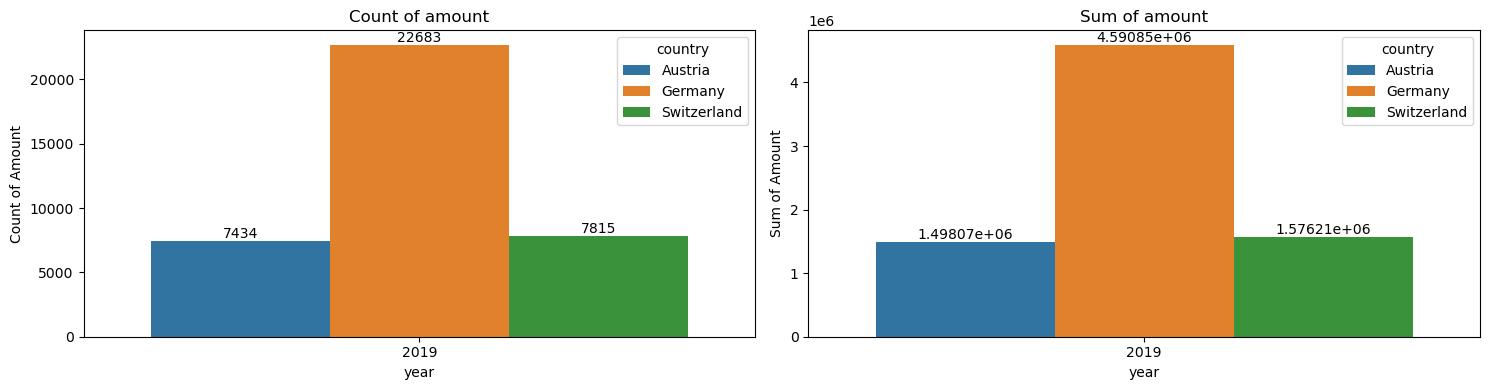

Month against amount by country


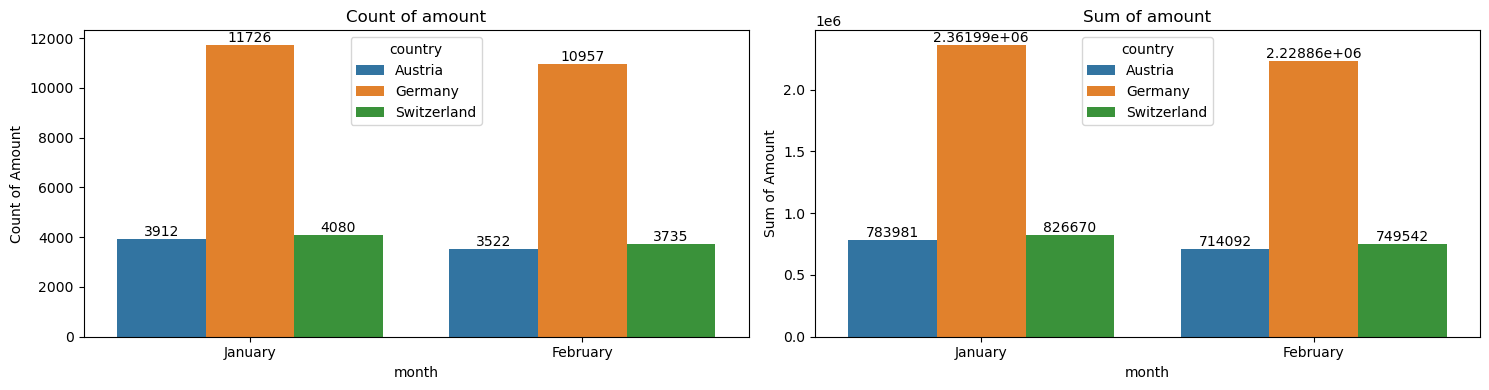

Day_of_month against amount bar chart by country


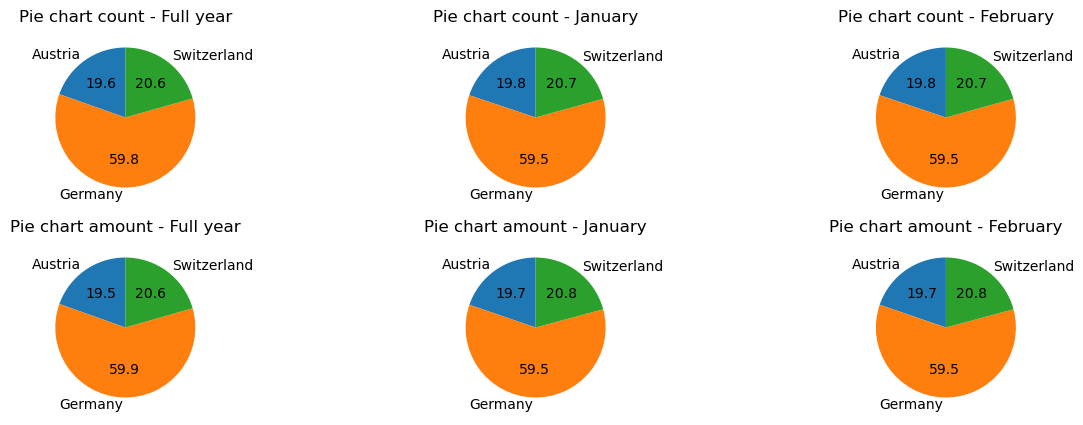

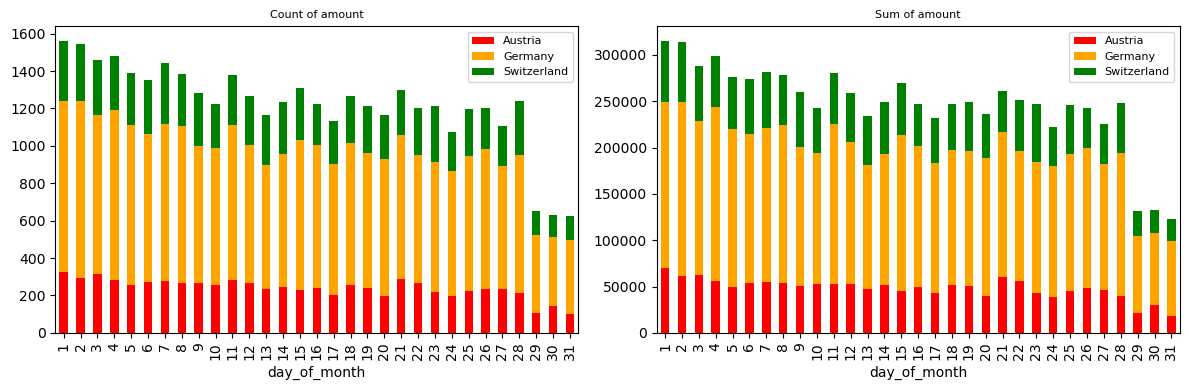

Day_of_month against amount bar chart by country - separated by month 


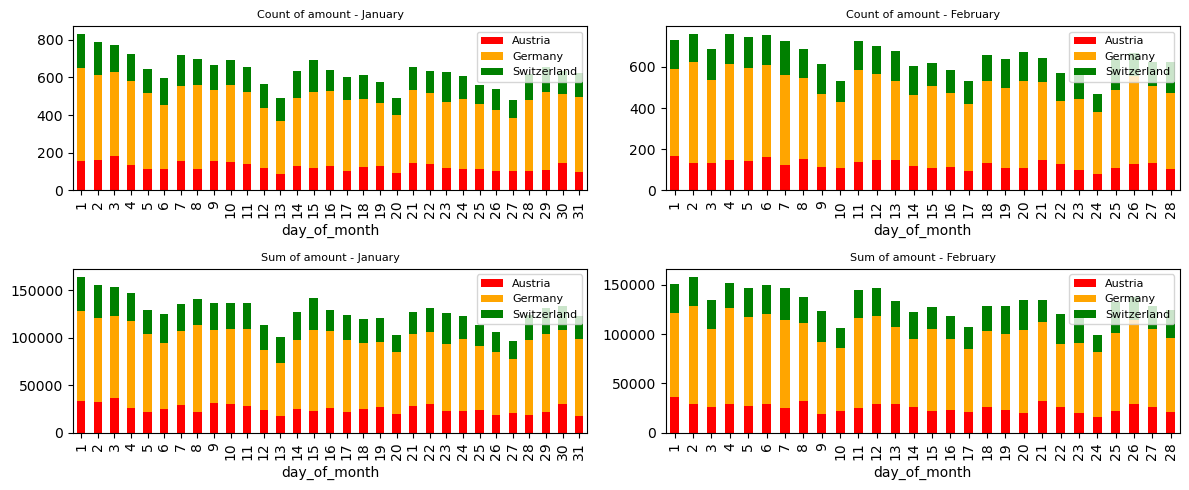

Day_of_month against amount by country


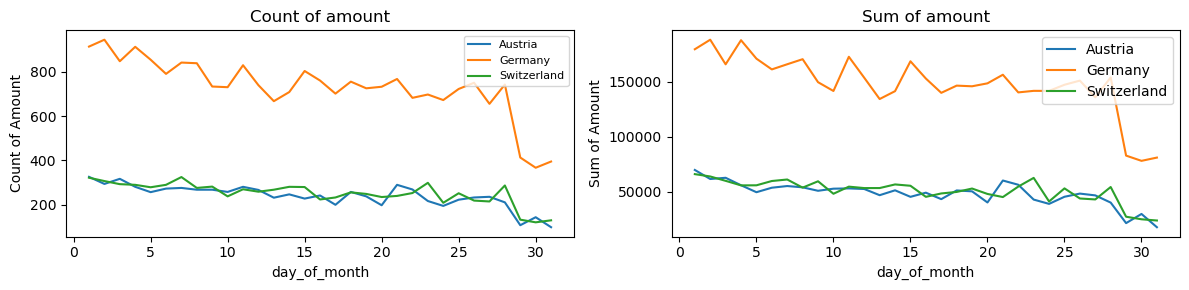

Day_of_month against amount by country separated by month


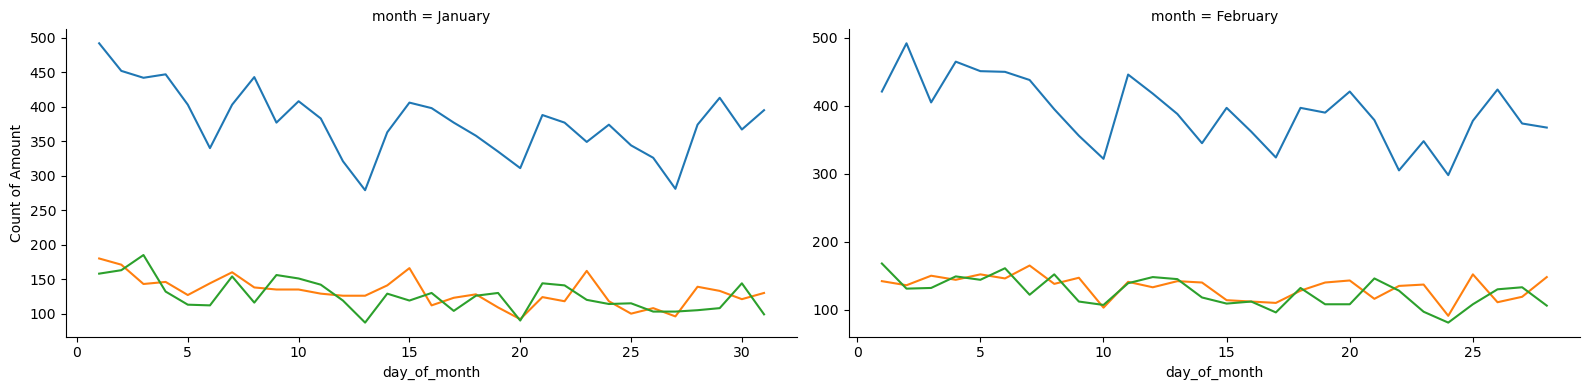

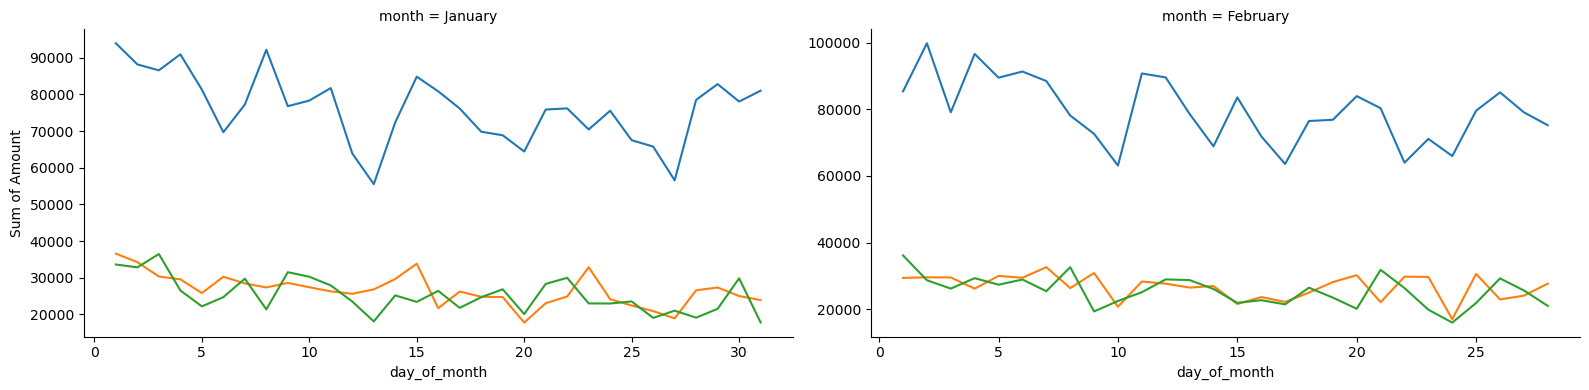

Day_of_month against amount for Austria


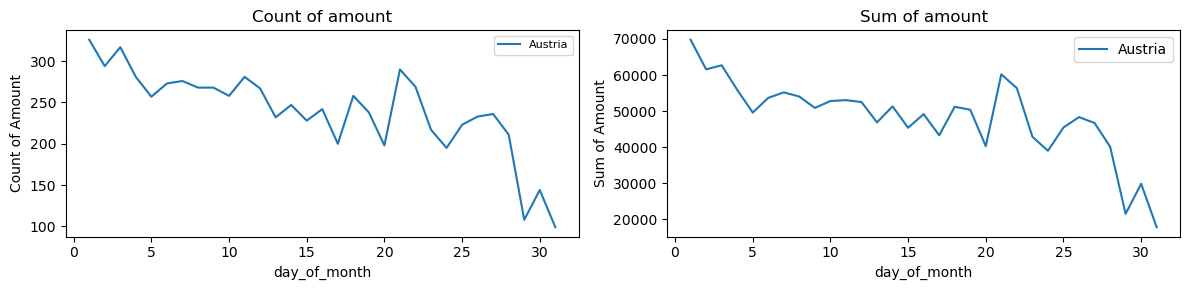

Day_of_month against amount for Austria separated by month


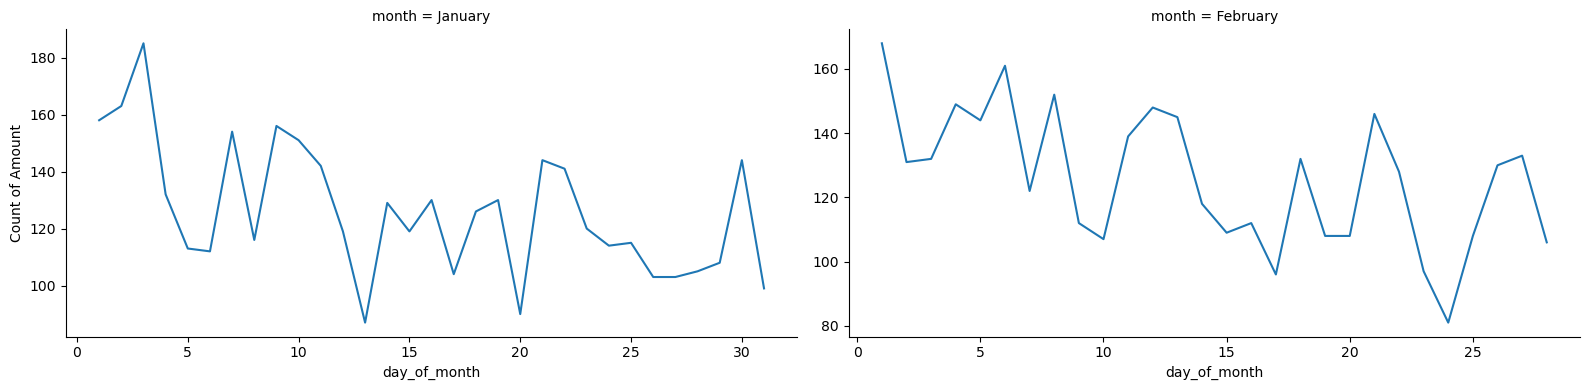

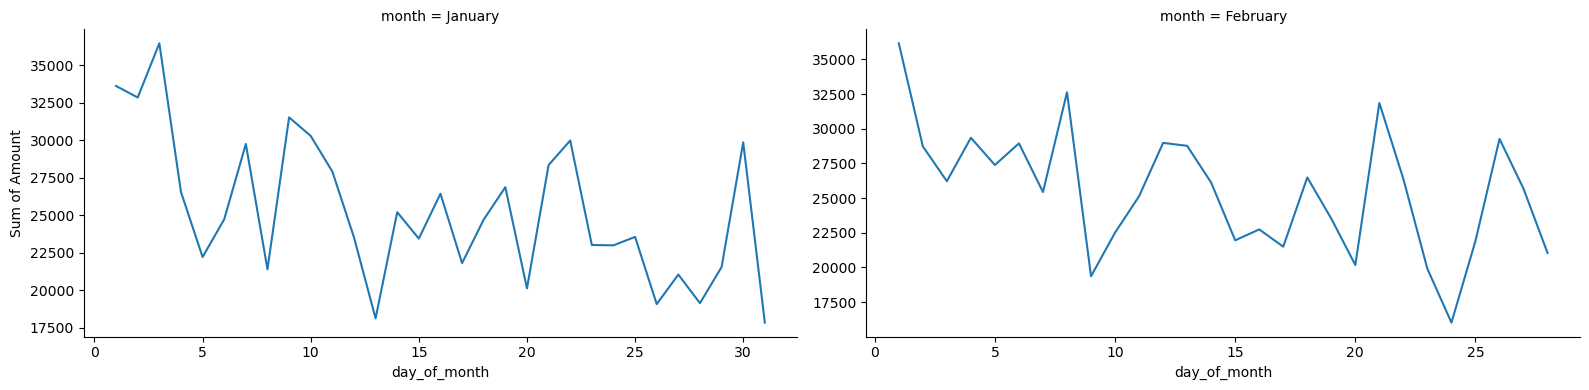

Day_of_month against amount for Germany


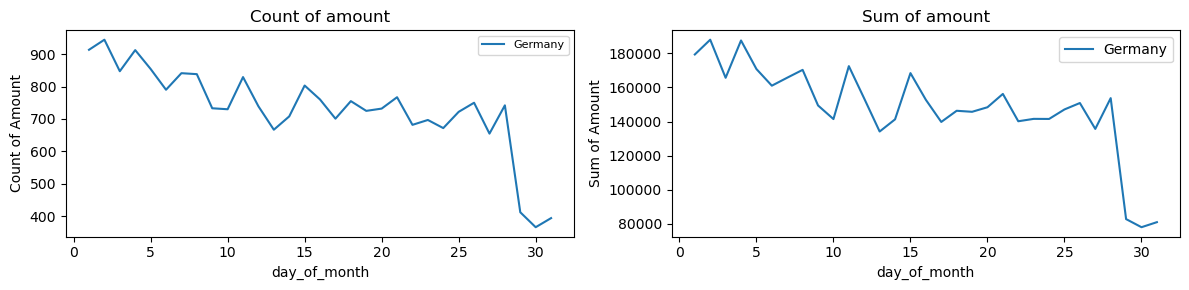

Day_of_month against amount for Germany separated by month


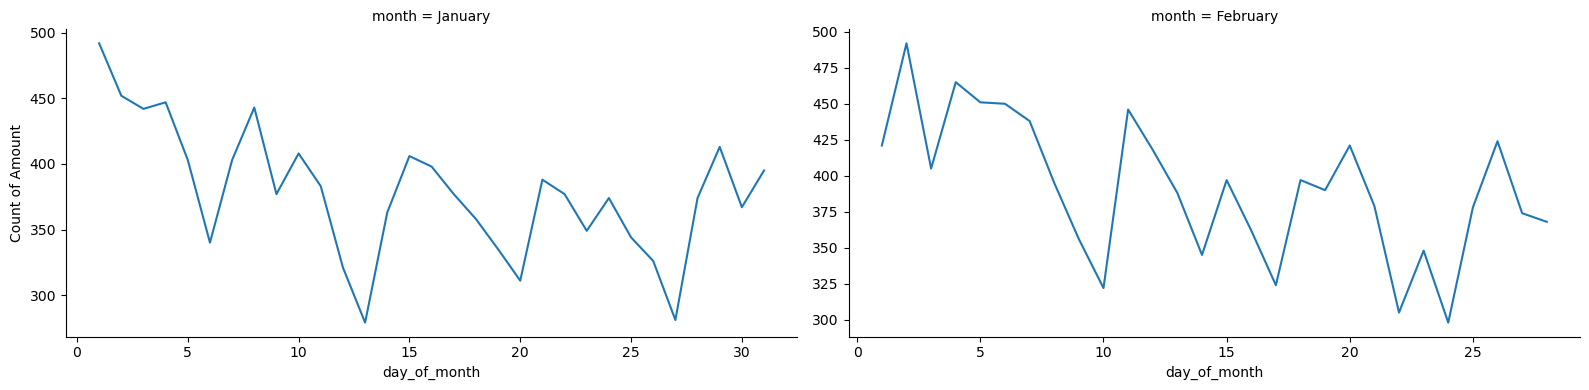

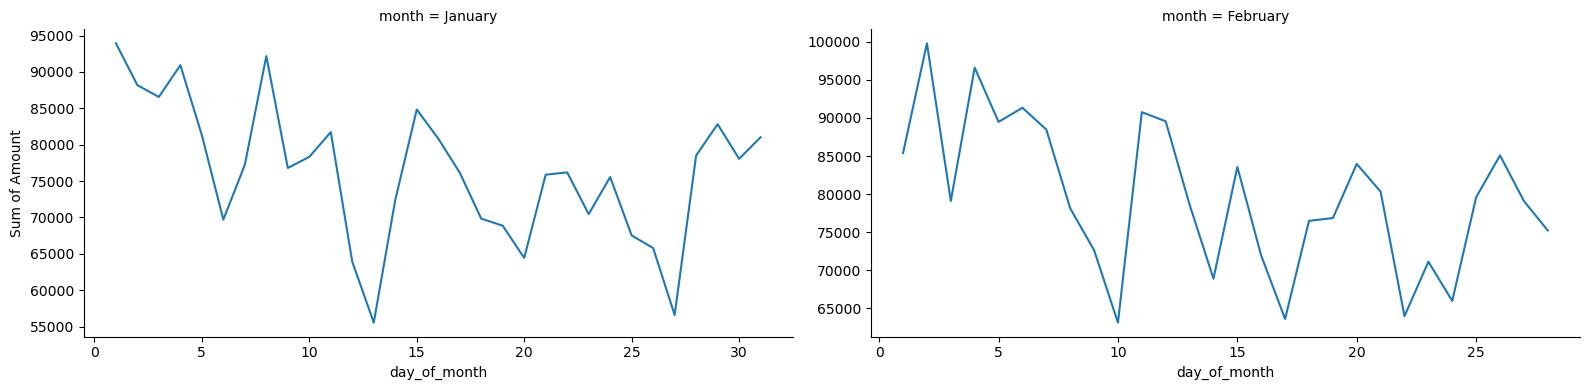

Day_of_month against amount for Switzerland


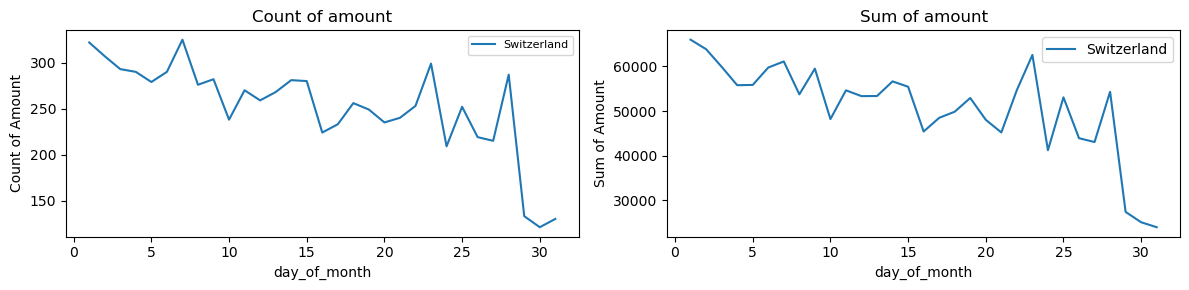

Day_of_month against amount for Switzerland separated by month


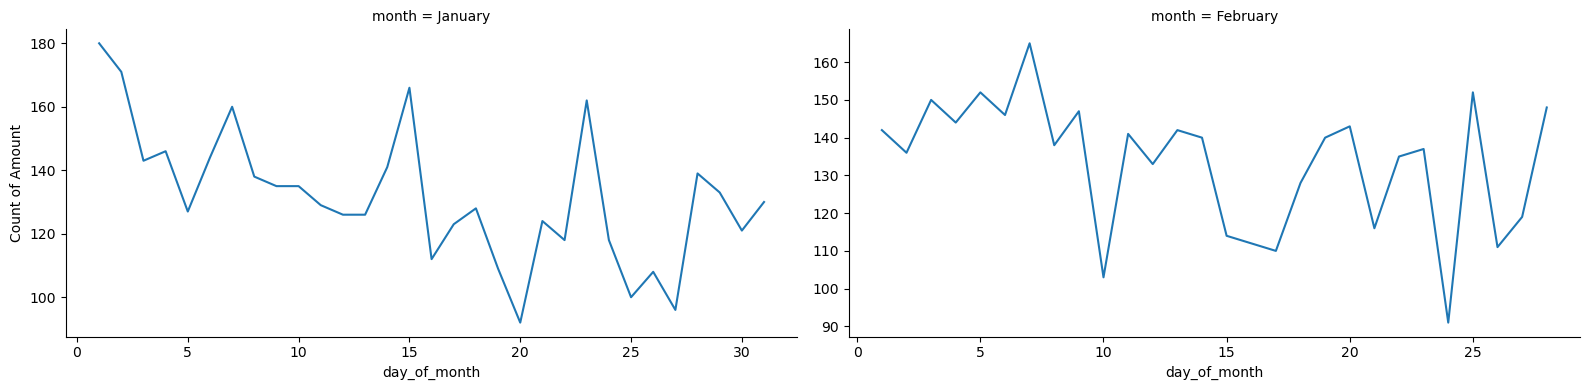

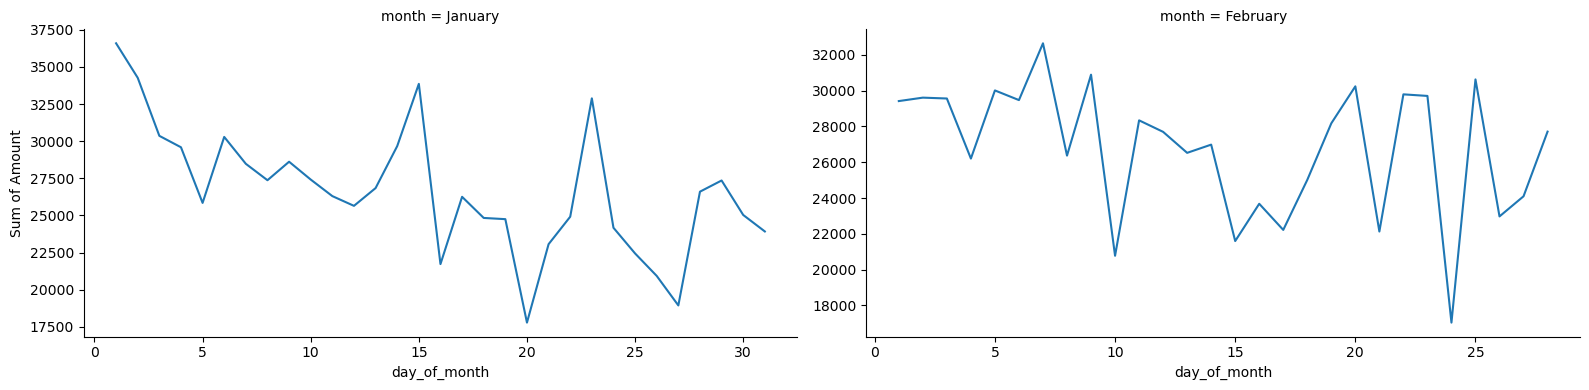

Day_of_week against amount bar chart by country


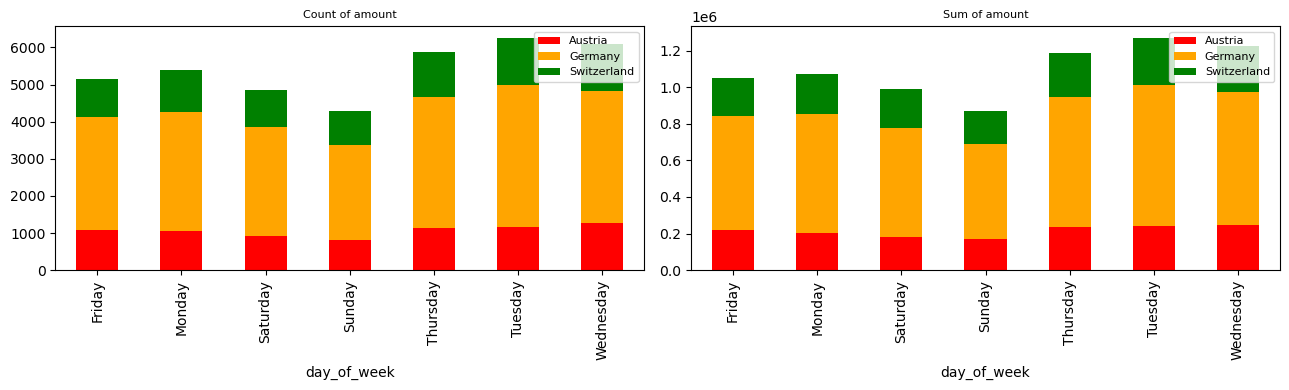

Day_of_week against amount bar chart by country - separated by month 


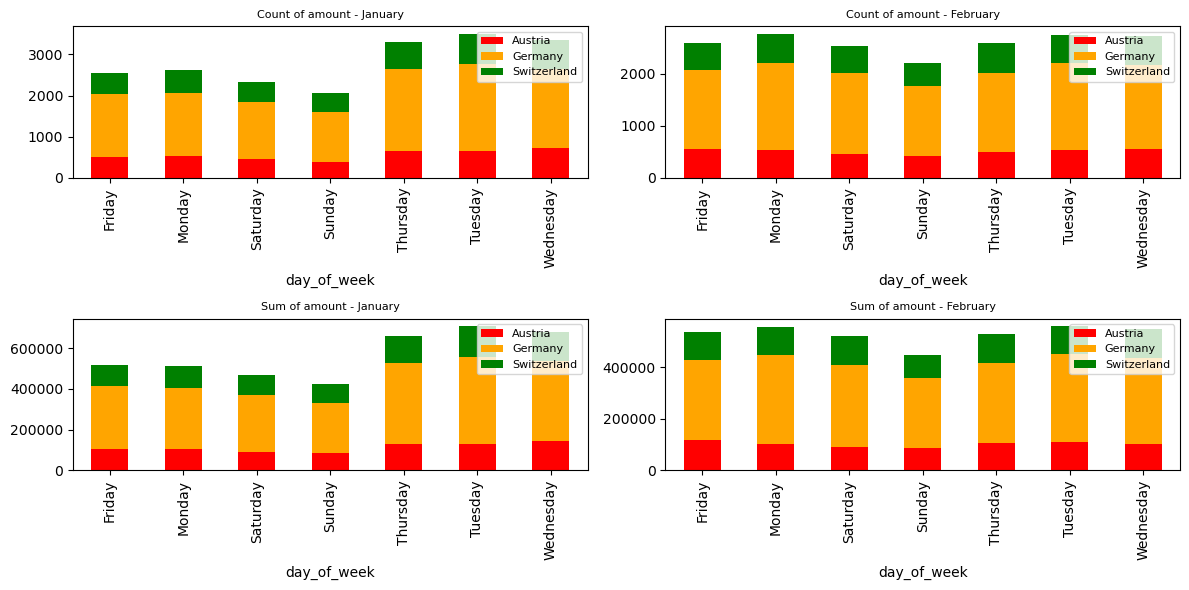

Day_of_week against amount by country


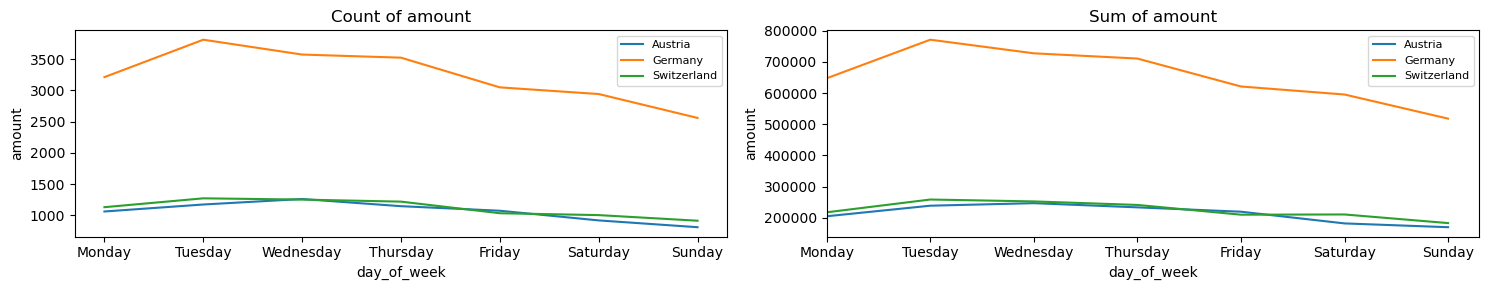

Day_of_week against amount by country separated by month


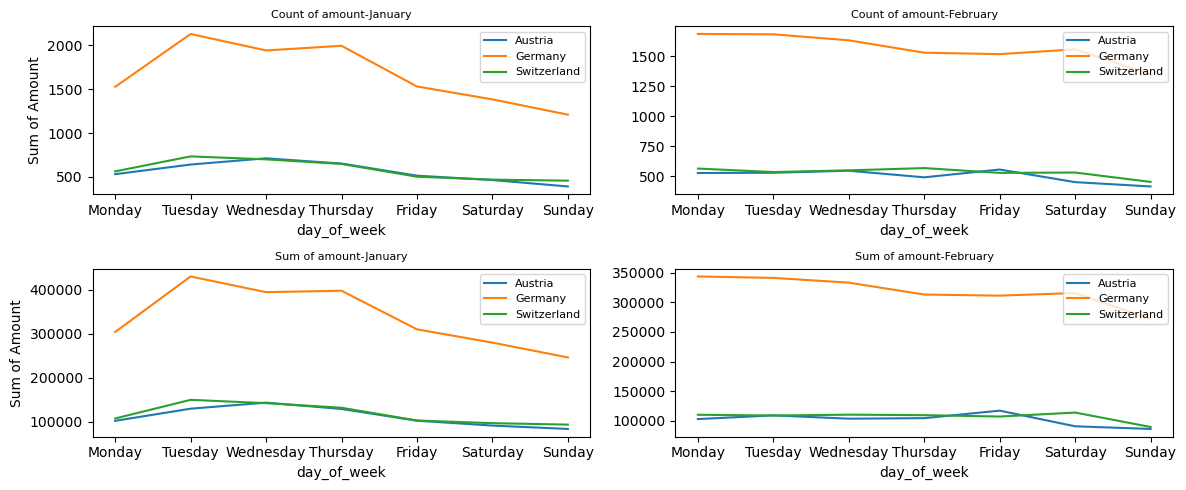

Day_of_week against amount for Austria


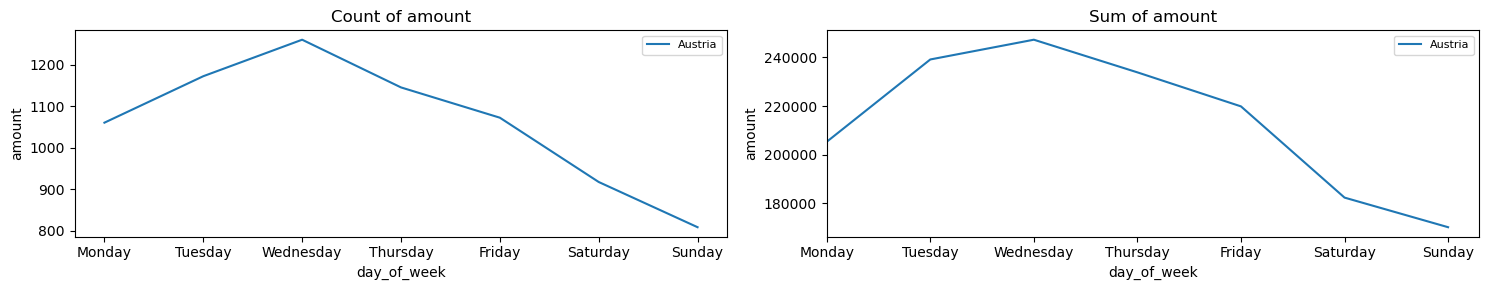

Day_of_week against amount for Austria separated by month


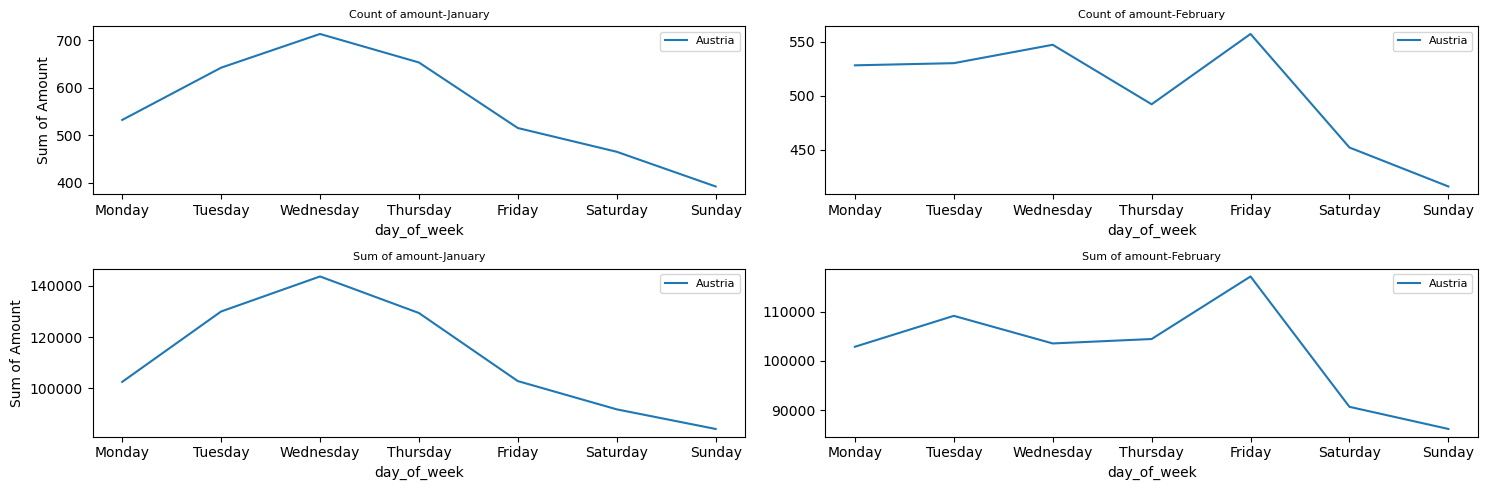

Day_of_week against amount for Germany


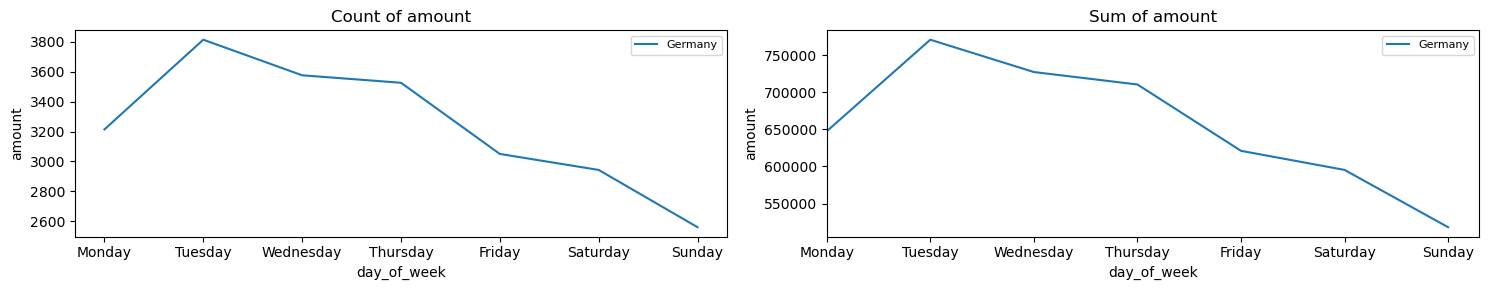

Day_of_week against amount for Germany separated by month


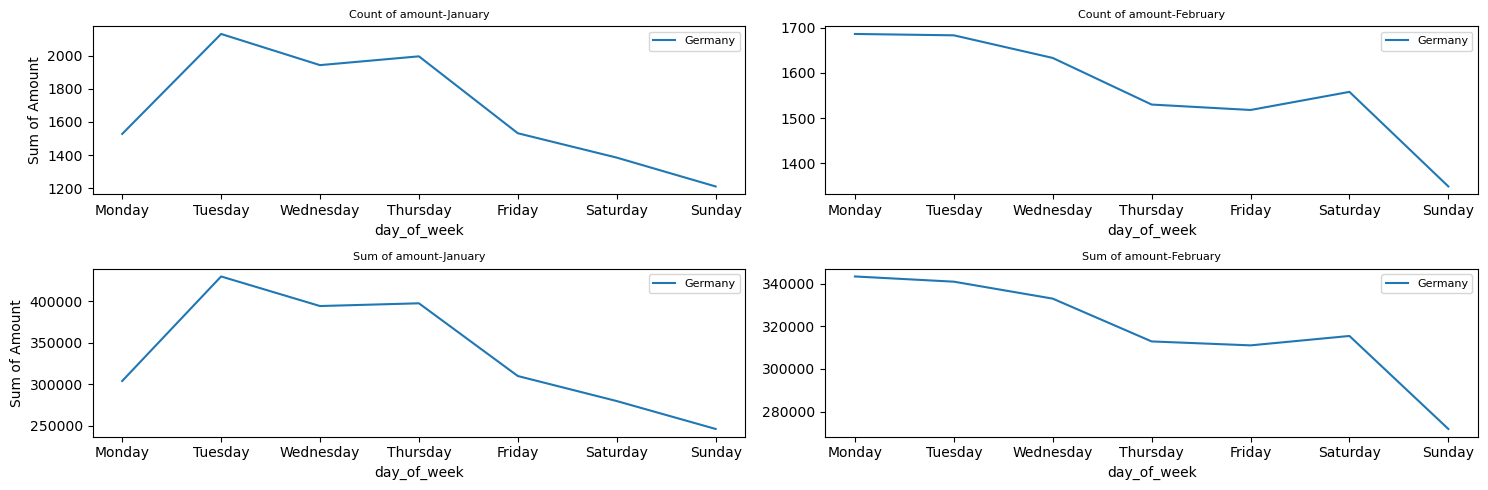

Day_of_week against amount for Switzerland


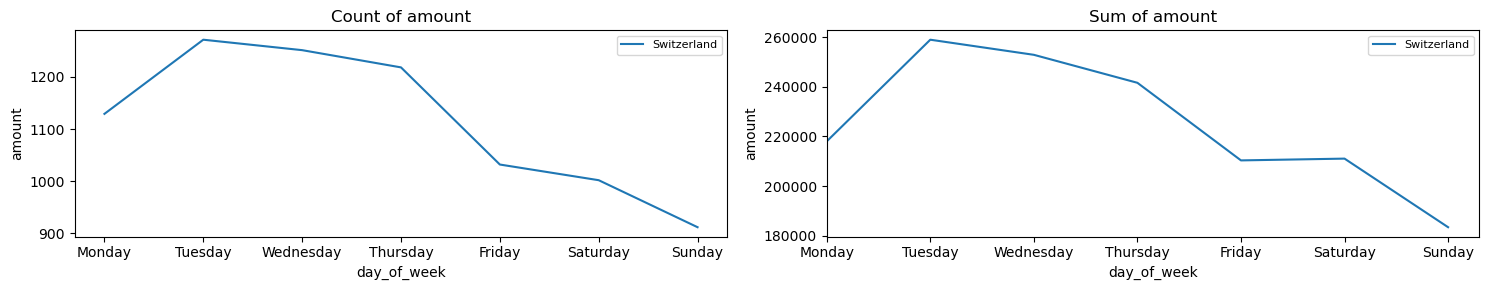

Day_of_week against amount for Switzerland separated by month


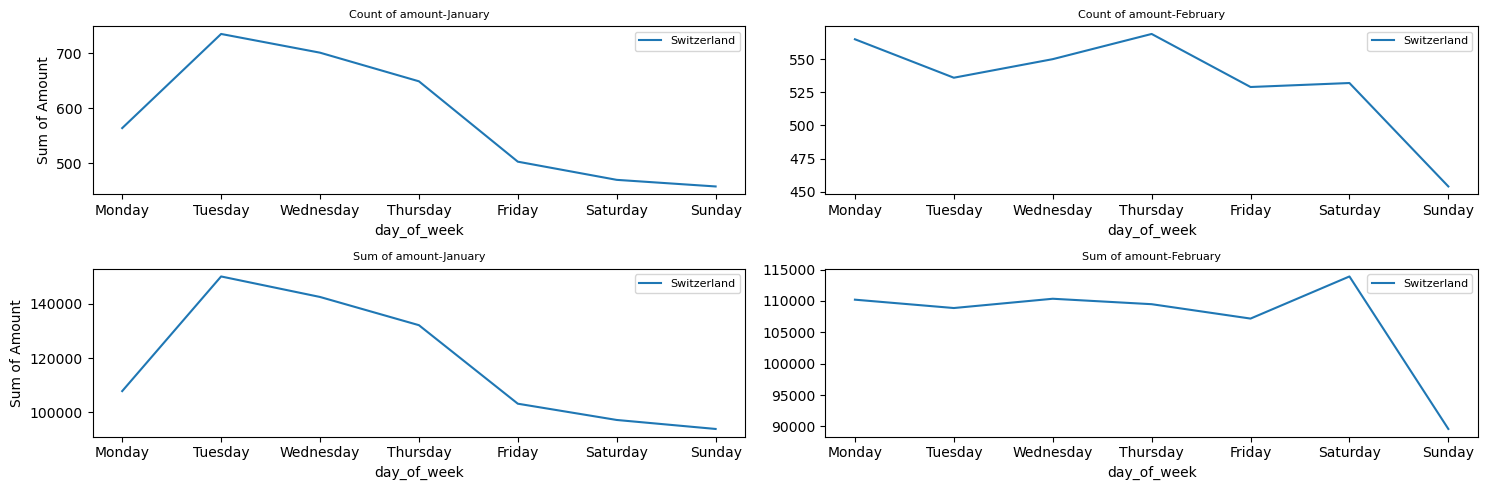

Hour against amount by                      tmsp      country  amount  success         PSP  \
0     2019-01-01 00:01:11      Germany      89        0     UK_Card   
1     2019-01-01 00:02:49      Germany     238        0     UK_Card   
2     2019-01-01 00:04:33      Austria     124        0  Simplecard   
3     2019-01-01 00:06:41  Switzerland     282        0     UK_Card   
4     2019-01-01 00:07:19  Switzerland     282        0  Simplecard   
...                   ...          ...     ...      ...         ...   
37927 2019-02-28 23:36:08  Switzerland     242        1     UK_Card   
37928 2019-02-28 23:43:36  Switzerland     208        0  Simplecard   
37929 2019-02-28 23:45:39  Switzerland     415        0     UK_Card   
37930 2019-02-28 23:46:48      Austria      91        0     UK_Card   
37931 2019-02-28 23:48:19      Austria      91        1   Moneycard   

       3D_secured    card  time_delta  tx_number  date_order  country_num  \
0               0    Visa         0.0          

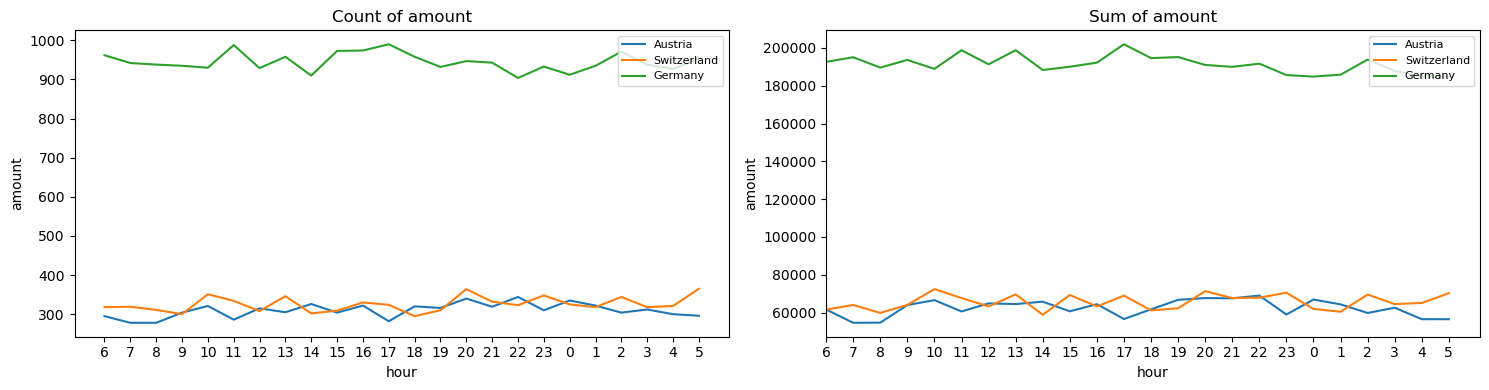

Hour against amount by country - separated by month 


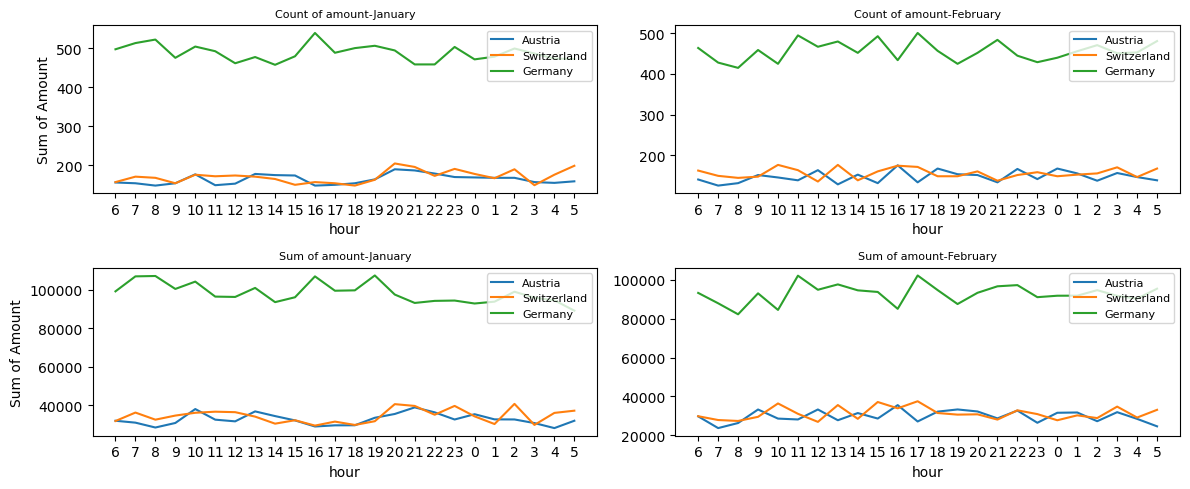

Hour against amount for Austria


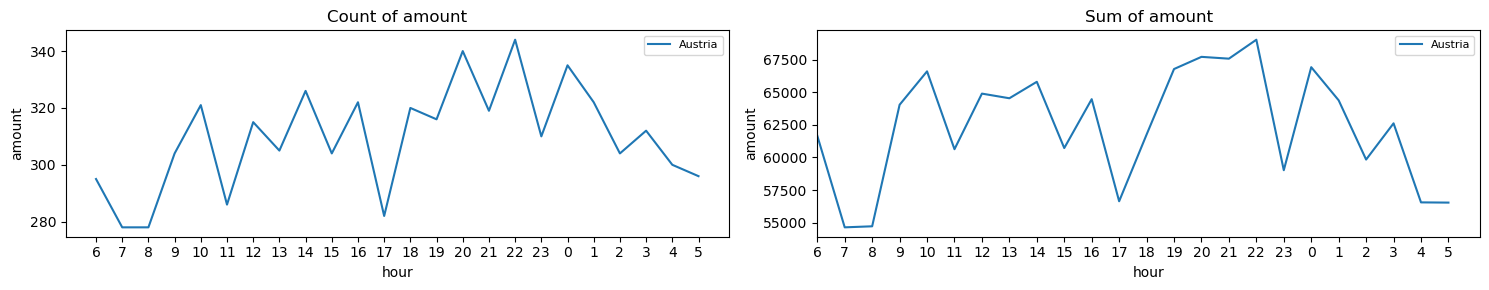

Hour against amount for Austria separated by month


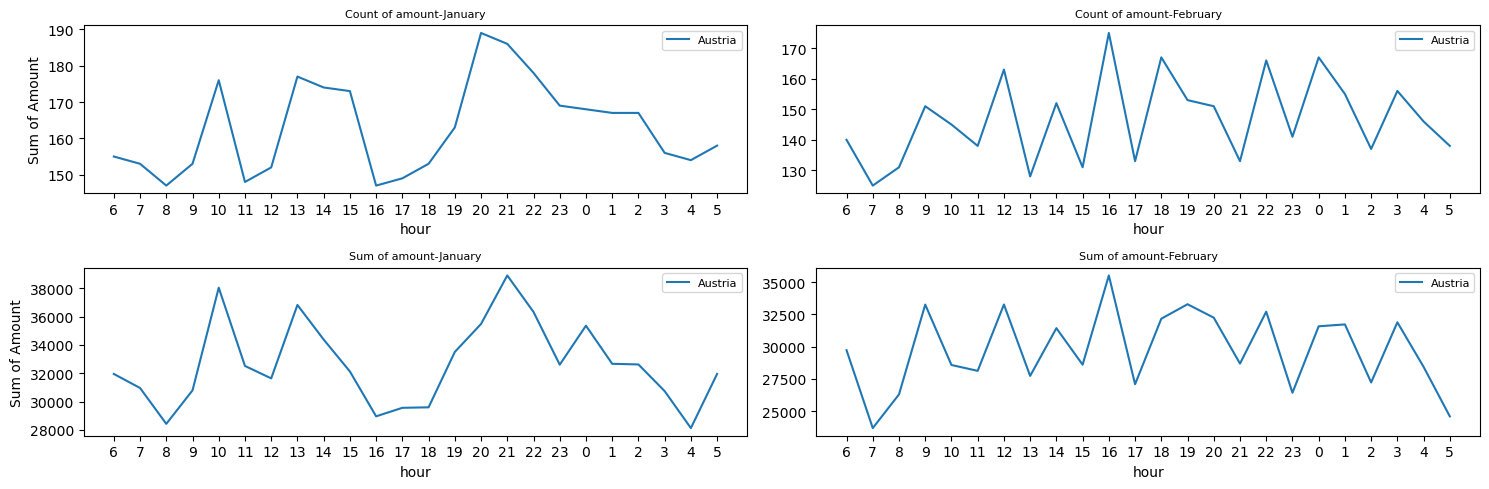

Hour against amount for Germany


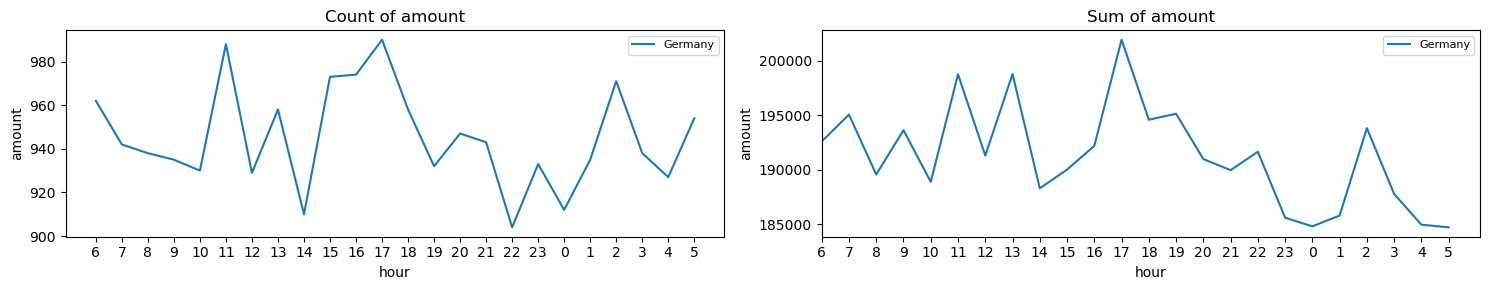

Hour against amount for Germany separated by month


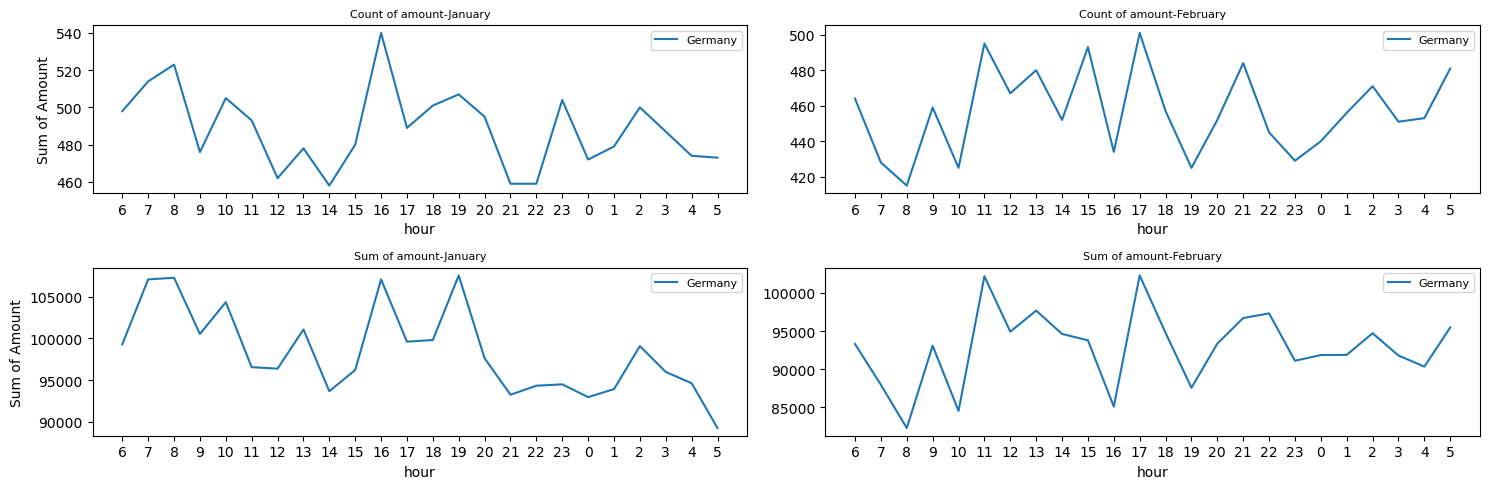

Hour against amount for Switzerland


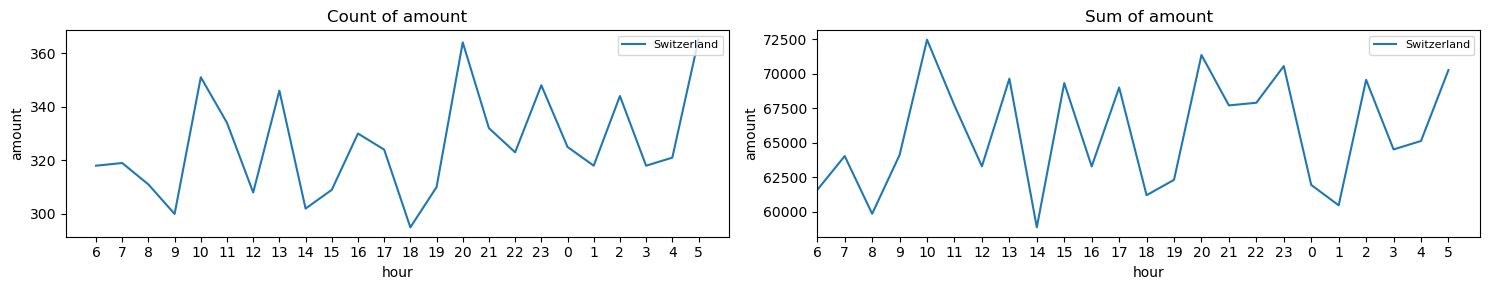

Hour against amount for Switzerland separated by month


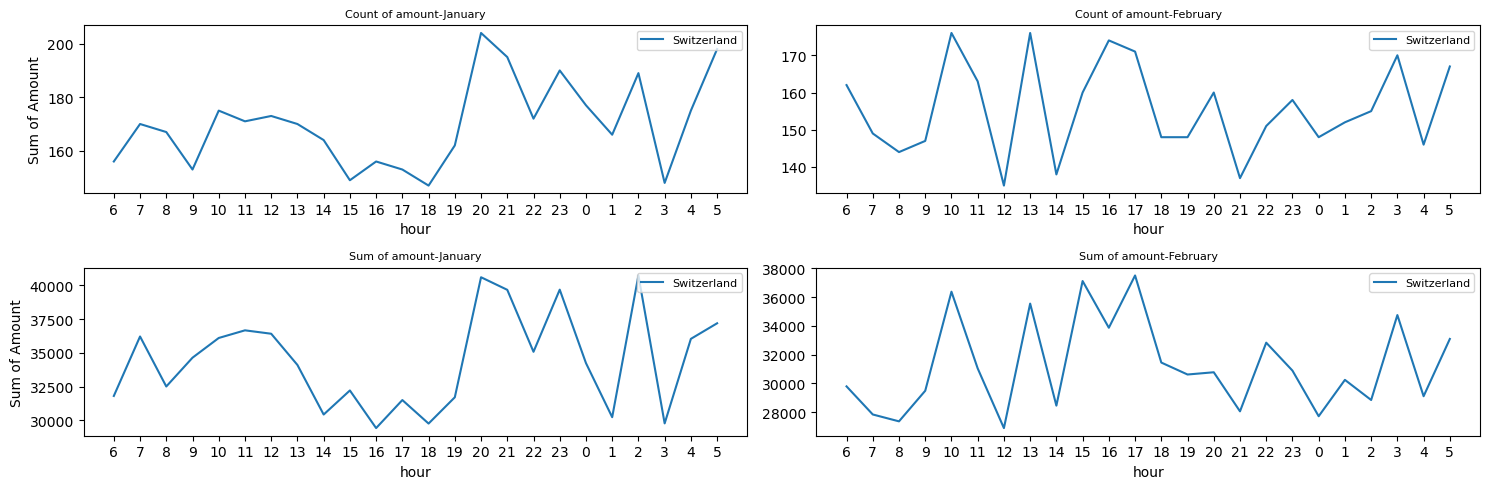

In [50]:
plot_categorical_features(dataset_time, 'country', color_list=['red', 'orange', 'green'], number_of_categories=3)

#### Plot Success time series against dummy variables

In [51]:
#plot_categorical_features(dataset_time, 'success', color_list=['green', 'orange'], number_of_categories=2)

In [52]:
plot_categorical_features(dataset_time, 'success', color_list=['green', 'orange'], number_of_categories=2)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2875392853.py, line 1)

#### Plot PSP time series against dummy variables

In [ ]:
plot_categorical_features(dataset_time, 'PSP', color_list=['blue','red', 'green', 'orange'], number_of_categories=4)

#### Plot 3D_secured time series against dummy variables

In [ ]:
plot_categorical_features(dataset_time, '3D_secured', color_list=['green', 'orange'], number_of_categories=2)

#### Plot card time series against dummy variables

In [ ]:
plot_categorical_features(dataset_time, 'card', color_list=['red', 'orange', 'green'], number_of_categories=3)